In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import infoshare.utils as utils

In [3]:
# which tags we'll keep for each task
KEEP_TAGS = {
    "POS": ["NOUN", "ADJ", "VERB", "PRON", "DET", "NUM", "ADV", "AUX"],
    "DEP": ["PUNCT", "NSUBJ", "OBJ", "OBL", "ADVCL", "CASE", "DET", "AMOD"],
}

In [4]:
# plotting config
sns.set_style("white")
# in inches
TEXTWIDTH = 6.30045
COLWIDTH = 3.03209
# colormap to use
cmap = sns.diverging_palette(20, 145, as_cmap=True)
# dictionary of label font config
label_dict = {"weight": "bold"}

## Task-level Cross-Neutralisation

### RoBERTa

Here we plot filtered cross-neutralization for the POS task on the en_gum dataset using embeddings from RoBERTa.

In [5]:
# determining best probing layer and aggregation function
pos_experiments_df = utils.get_experiments_df(
    "POS", "en_gum", "roberta-base", "../lightning_logs"
)
pos_mode = utils.select_best_mode(pos_experiments_df)
pos_eval_path = f"../lightning_logs/roberta-base/en_gum/POS/{pos_mode}/evaluation"

#### Main Body

In [6]:
# computing accuracy drop due to neutralisation
pos_acc_drop_main = utils.get_acc_drop(pos_eval_path, keep_cols=KEEP_TAGS['POS'])

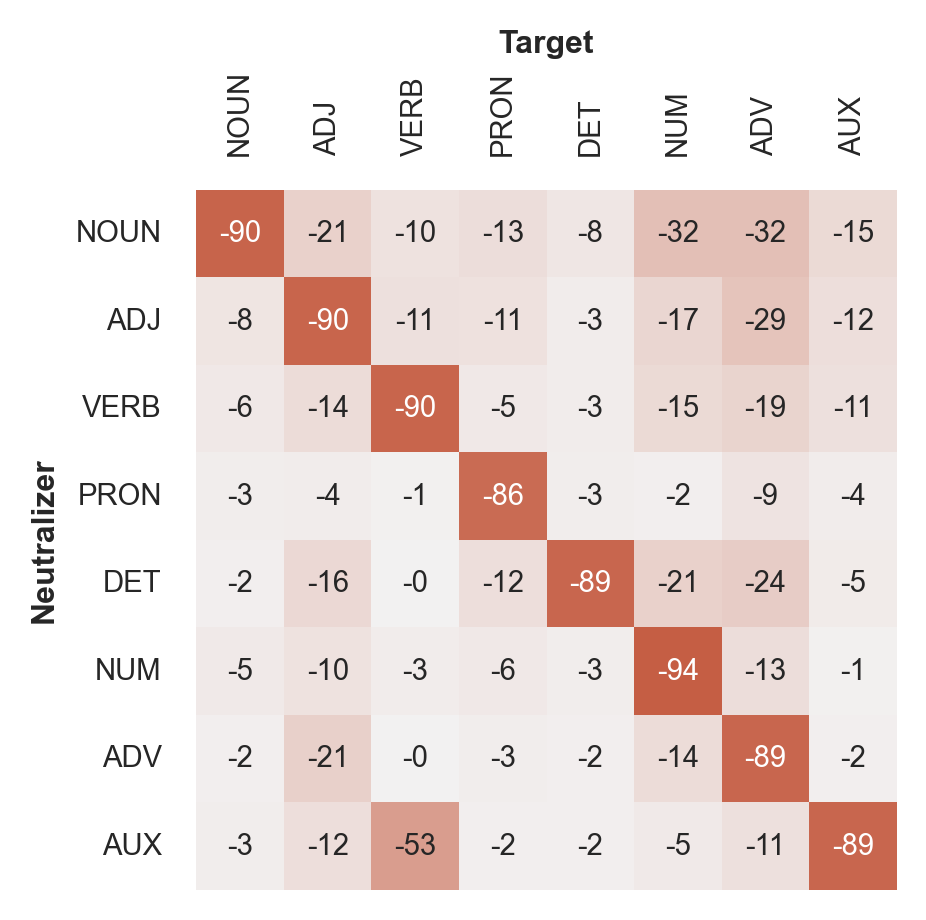

In [7]:
# plot
sns.set_context("paper", font_scale=0.8)
f, ax1 = plt.subplots(1, 1, figsize=(COLWIDTH, COLWIDTH), dpi=300)
ax1 = sns.heatmap(
    pos_acc_drop_main * 100,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0f",
    cmap=cmap,
    cbar=False,
    ax=ax1,
    vmin=-100,
    vmax=100,
    center=0,
    square=True,
)
ax1.set_xlabel(ax1.get_xlabel(), fontdict=label_dict)

ax1.tick_params(
    axis="x",
    which="major",
    top=False,
    labeltop=True,
    labelbottom=False,
    labelrotation=90,
)
ax1.xaxis.set_label_position('top') 
ax1.tick_params(
    axis="y",
    which="major",
    left=False,
    labelrotation=0,
)
ax1.set_ylabel(ax1.get_ylabel(), fontdict=label_dict)

# f.set_tight_layout(True)
# save our figure
plt.savefig("../images/final/pos-xn-roberta-main.eps", bbox_inches="tight")
plt.show()

#### Appendix

In [8]:
# computing accuracy drop due to neutralisation
pos_acc_drop_appendix = utils.get_acc_drop(pos_eval_path, keep_cols=None)

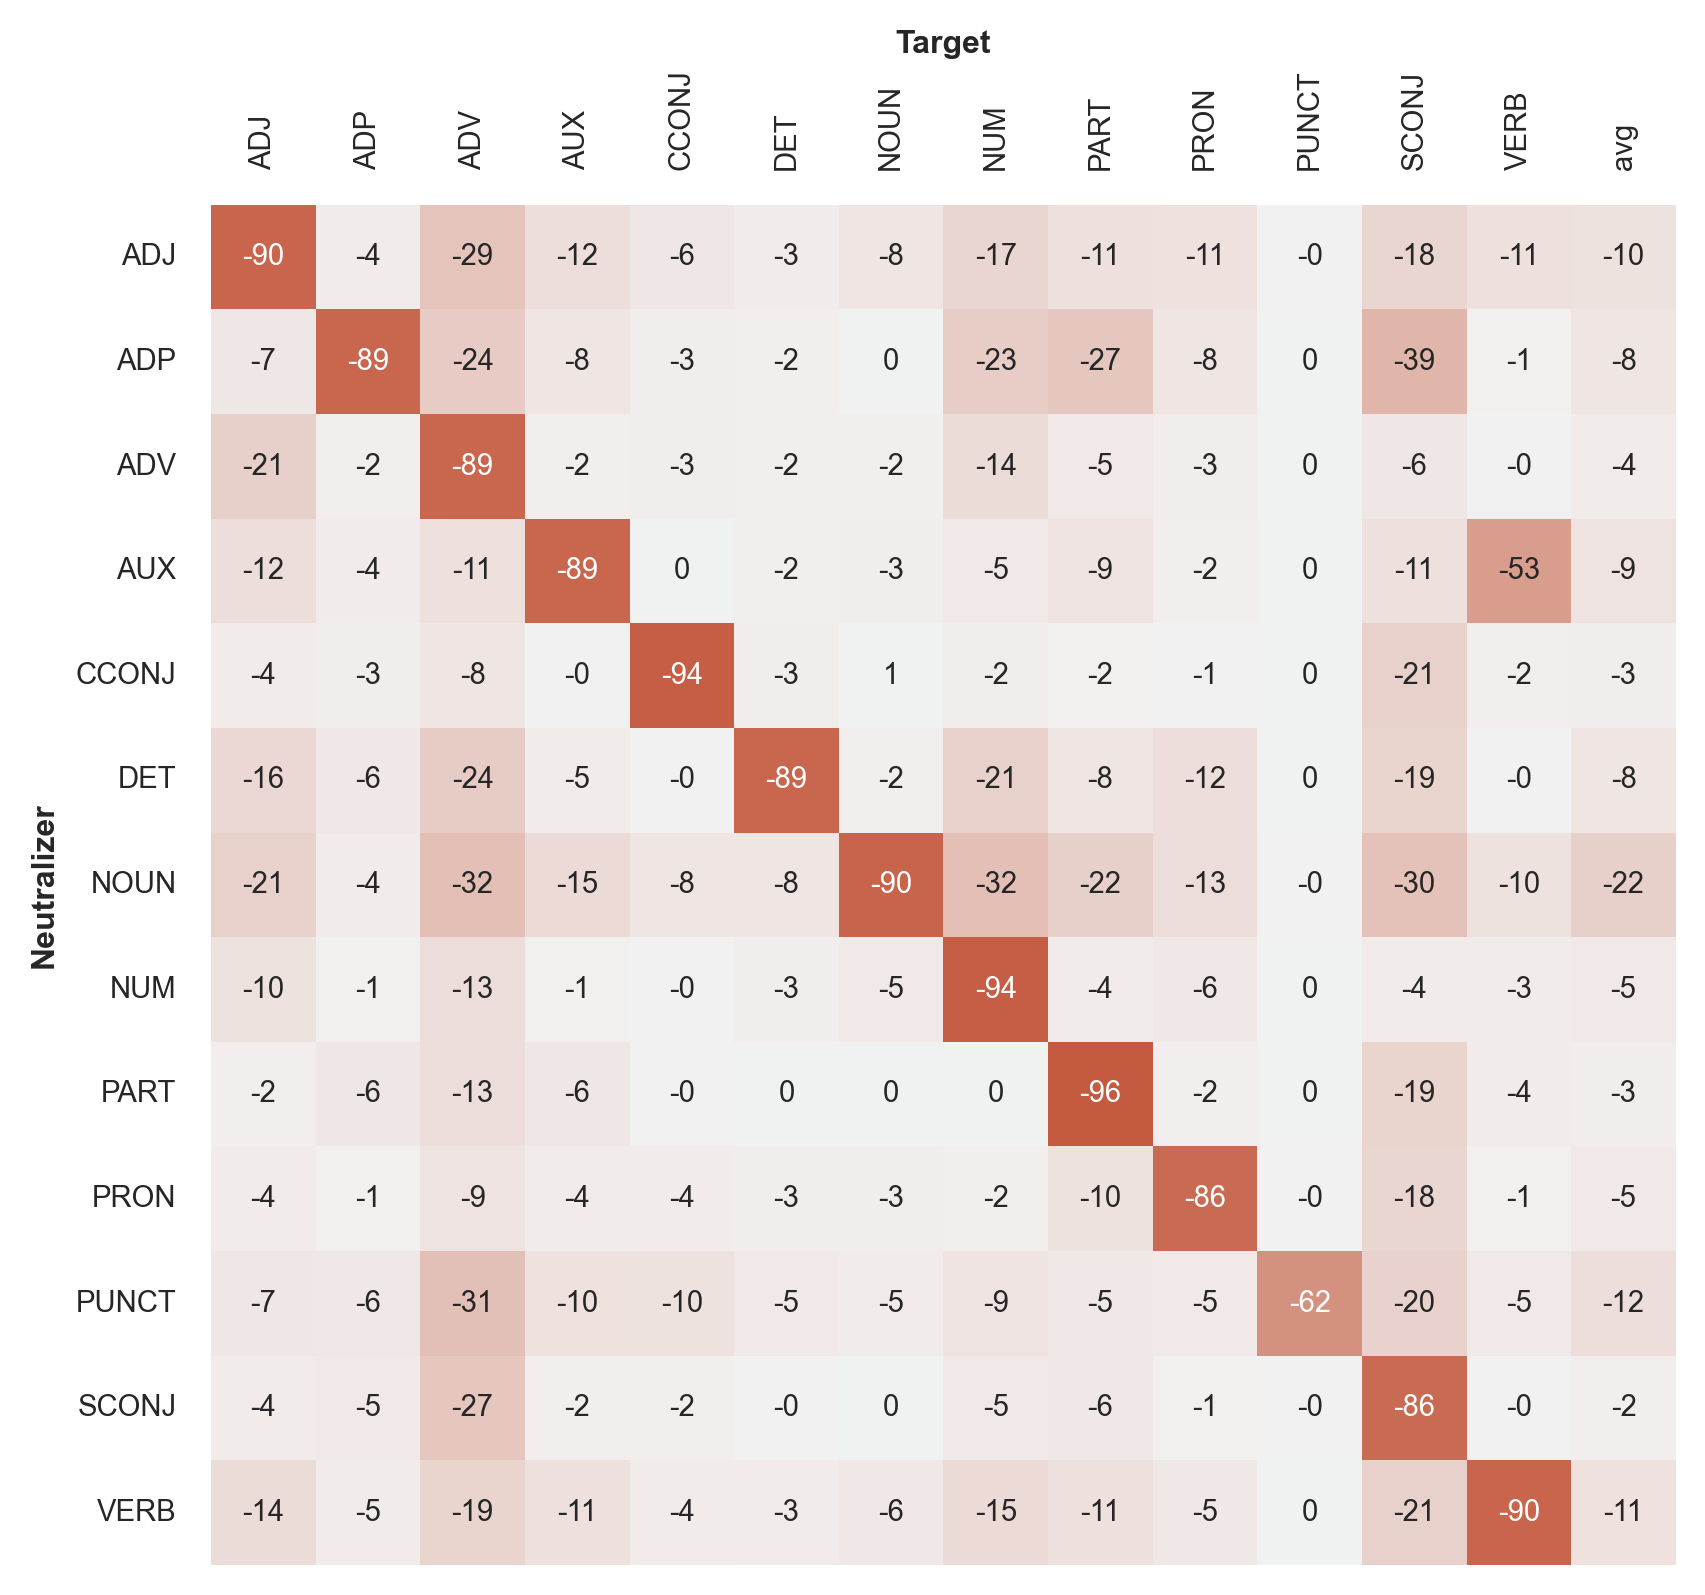

In [9]:
# plot
sns.set_context("paper", font_scale=0.8)
f, ax1 = plt.subplots(1, 1, figsize=(TEXTWIDTH, TEXTWIDTH), dpi=300)
ax1 = sns.heatmap(
    pos_acc_drop_appendix * 100,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0f",
    cmap=cmap,
    cbar=False,
    ax=ax1,
    vmin=-100,
    vmax=100,
    center=0,
    square=True,
)
ax1.set_xlabel(ax1.get_xlabel(), fontdict=label_dict)
ax1.set_ylabel(ax1.get_ylabel(), fontdict=label_dict)
ax1.tick_params(
    axis="x",
    which="major",
    top=False,
    labeltop=True,
    labelbottom=False,
    labelrotation=90,
)
ax1.xaxis.set_label_position('top') 
ax1.tick_params(
    axis="y",
    which="major",
    left=False,
    labelrotation=0,
)

# f.set_tight_layout(True)
# save our figure
plt.savefig("../images/final/pos-xn-roberta-appendix.eps", bbox_inches="tight")
plt.show()

### XLM-R

Here we plot filtered cross-neutralization for the POS task on the en_gum, it_vit and el_gdt datasets using embeddings from XLM-R.

In [10]:
# Since we'll be doing much of the same stuff for three different languages, use a dict
lang_dict = {"en_gum": {}, "it_vit": {}, "el_gdt": {}}

In [11]:
# encapsulate logic from previous section in a function
def get_acc_drop(treebank, model):
    # determining best probing layer and aggregation function
    pos_experiments_df = utils.get_experiments_df(
        "POS", treebank, model, "../lightning_logs"
    )
    pos_mode = utils.select_best_mode(pos_experiments_df)
    
    # computing accuracy drop due to neutralisation
    pos_eval_path = f"../lightning_logs/{model}/{treebank}/POS/{pos_mode}/evaluation"
    pos_acc_drop_main = utils.get_acc_drop(pos_eval_path, KEEP_TAGS["POS"])
    pos_acc_drop_appendix = utils.get_acc_drop(pos_eval_path)
    
    
    return pos_acc_drop_main, pos_acc_drop_appendix, pos_mode

In [12]:
# can now populate our dictionary
for key in lang_dict.keys():
    pos_acc_drop_main, pos_acc_drop_appendix, pos_mode = get_acc_drop(
        key, "xlm-roberta-base"
    )
    lang_dict[key]["main"] = pos_acc_drop_main
    lang_dict[key]["appendix"] = pos_acc_drop_appendix
    lang_dict[key]["mode"] = pos_mode

In [13]:
[(k, v['mode']) for k, v in lang_dict.items()]

[('en_gum', 'agg=max_probe=9'),
 ('it_vit', 'agg=first_probe=9'),
 ('el_gdt', 'agg=mean_probe=12')]

#### Main Text

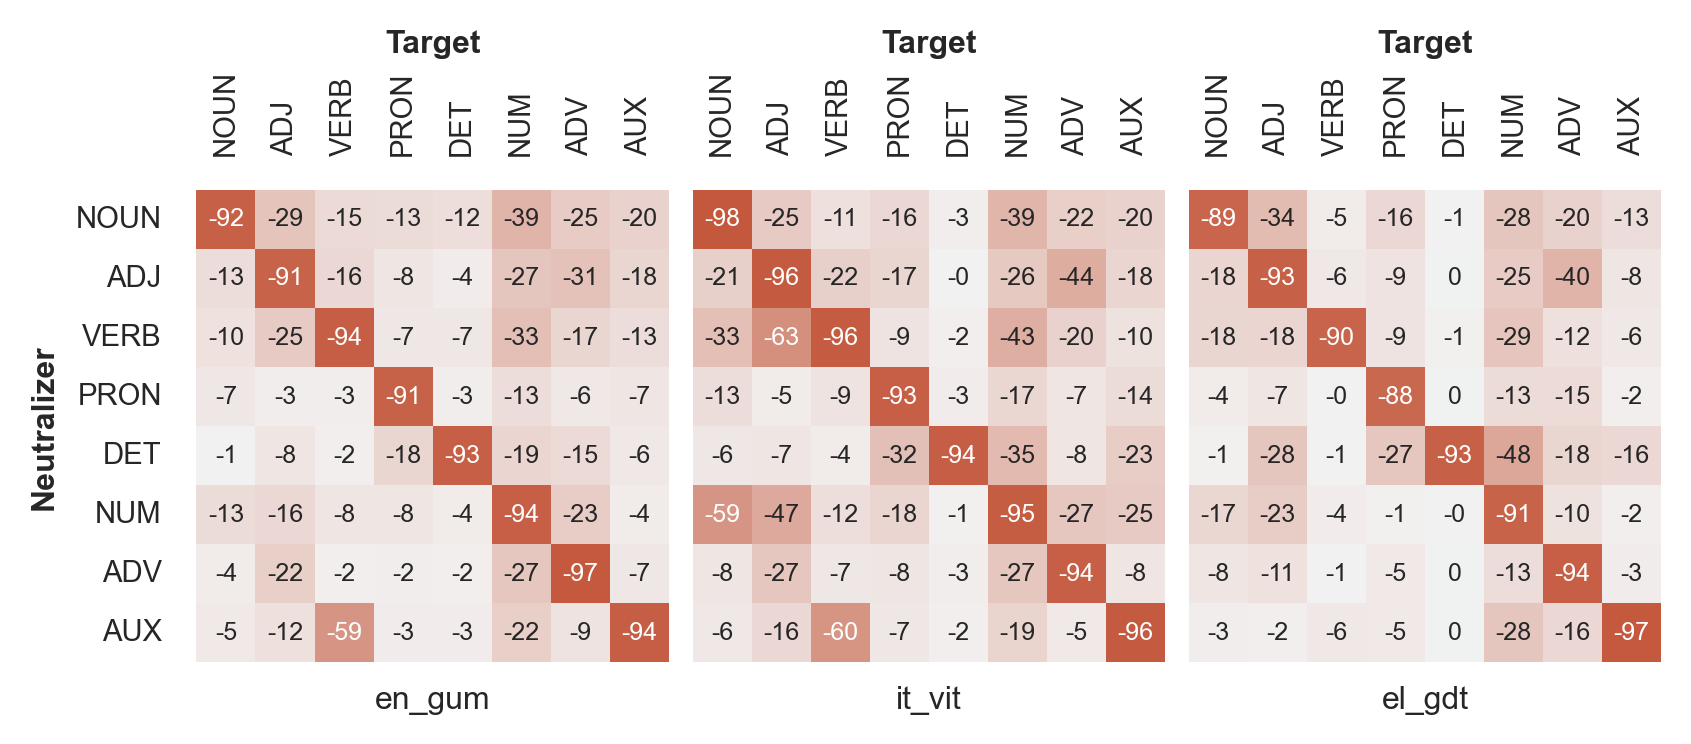

In [14]:
# using our dict, we plot our results
sns.set_context("paper", font_scale=0.8)
f, pos_row = plt.subplots(
    1, 3, figsize=(TEXTWIDTH, (TEXTWIDTH / 3)), dpi=300
)
for i, (treebank, lang) in enumerate(lang_dict.items()):
    ax_pos = pos_row[i]
    pos_acc_drop = lang["main"]

    ax_pos = sns.heatmap(
        pos_acc_drop * 100,
        annot=True,
        annot_kws={"fontsize": 6},
        fmt=".0f",
        cmap=cmap,
        cbar=False,
        ax=ax_pos,
        vmin=-100,
        vmax=100,
        center=0,
        square=True,
        yticklabels=False if i != 0 else True,
    )
    ax_pos.tick_params(
        axis="x",
        which="major",
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
        labelrotation=90,
    )
    ax_pos.set_xlabel('Target', fontdict=label_dict)
    ax_pos.xaxis.set_label_position('top')
    ax_pos.set_ylabel(None)
    ax_pos.set_title(treebank, y=-0.15)
    if i == 0:
        ax_pos.set_ylabel('Neutralizer', fontdict=label_dict)
         
# f.set_tight_layout(True)
plt.subplots_adjust(wspace=0.05)
plt.savefig("../images/final/pos-xn-xlm_r-main.eps", bbox_inches="tight")
plt.show()

#### Appendix

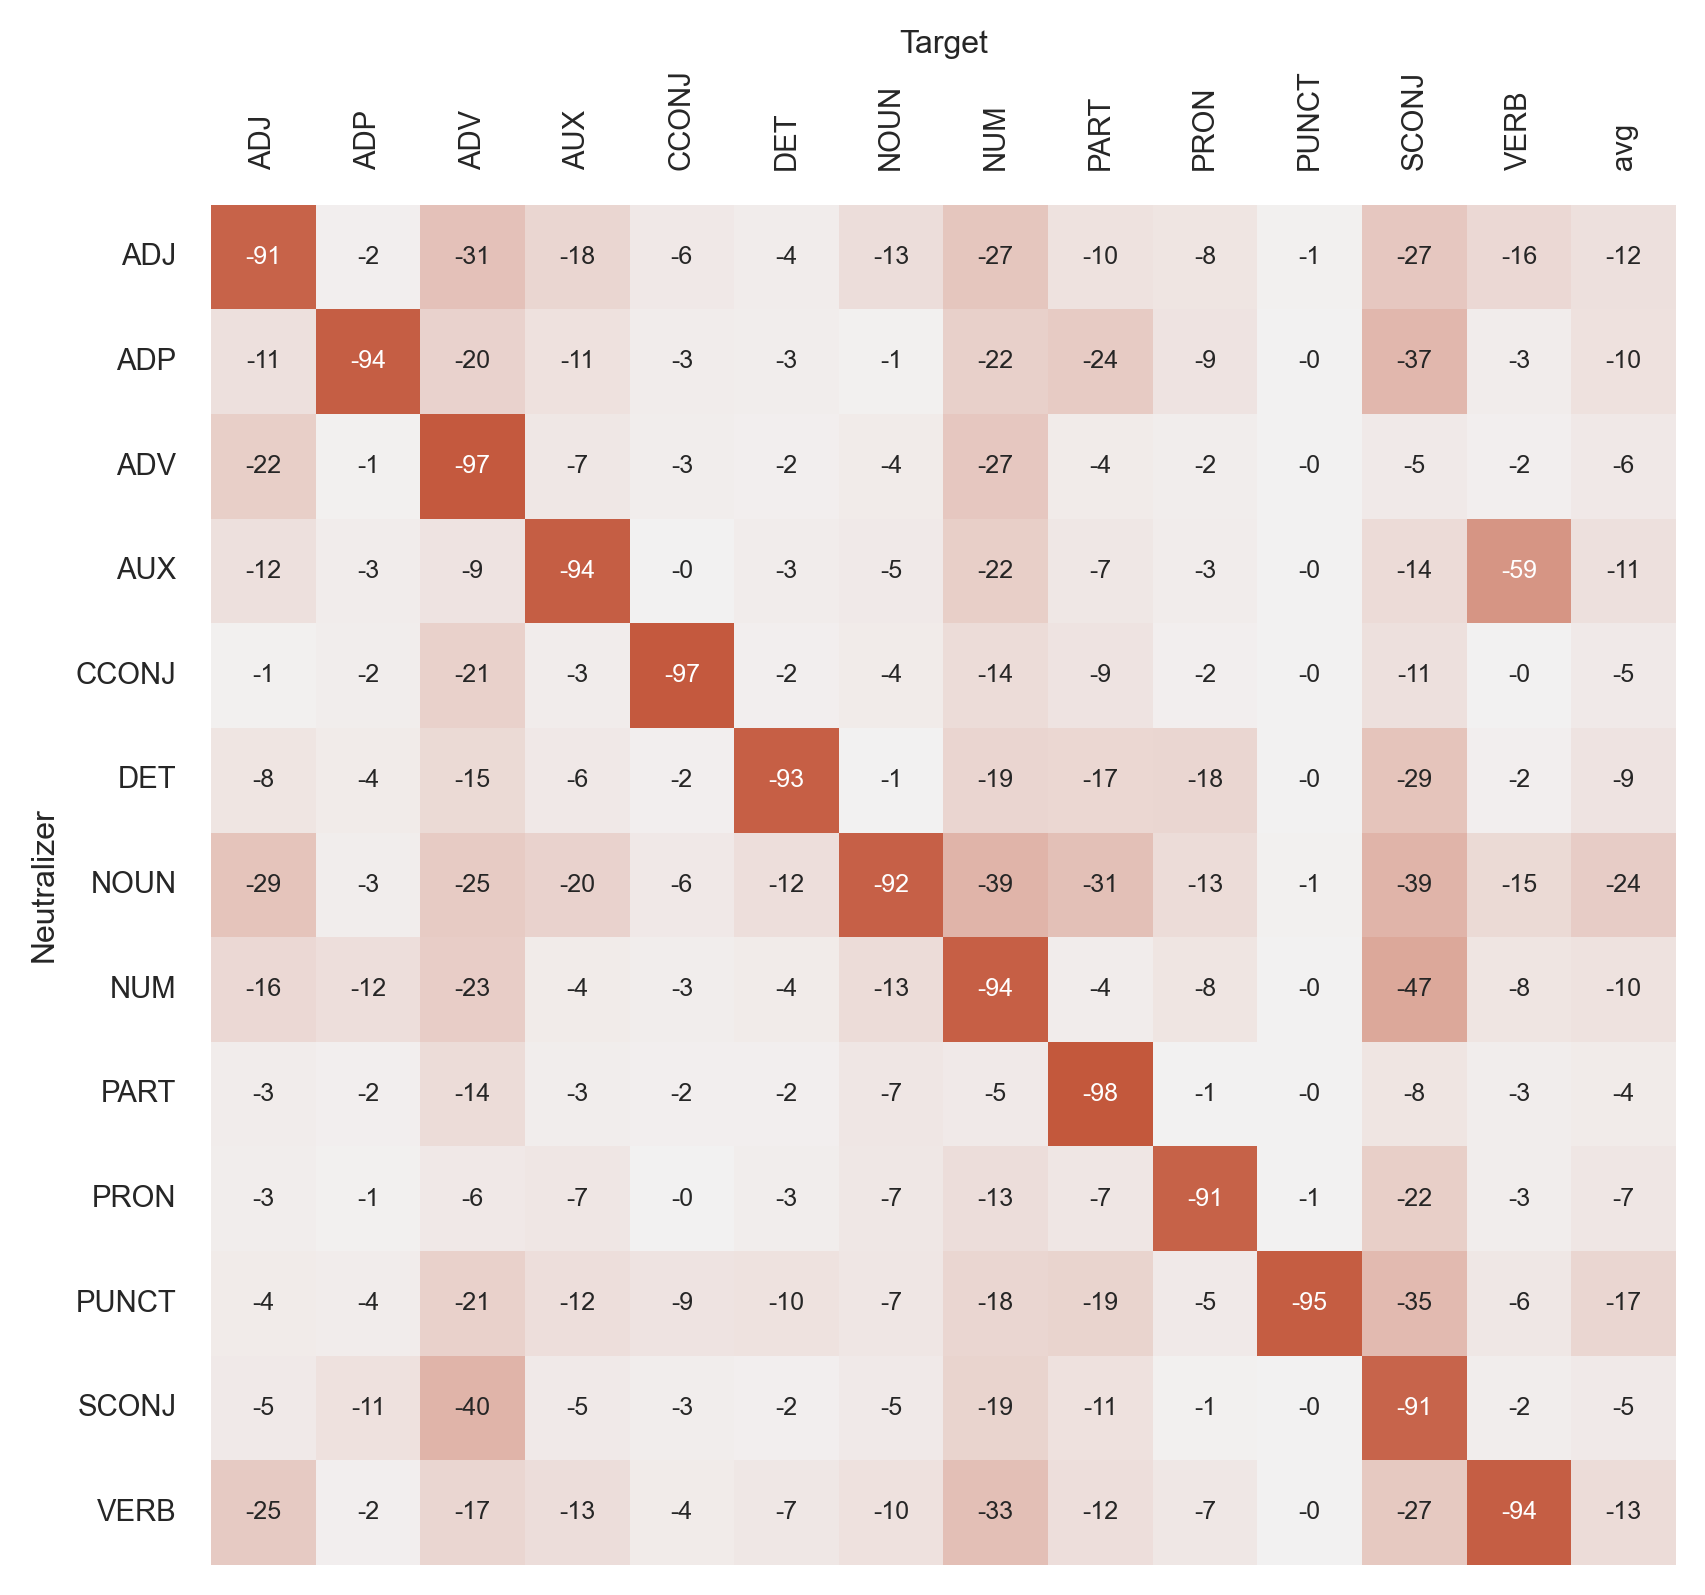

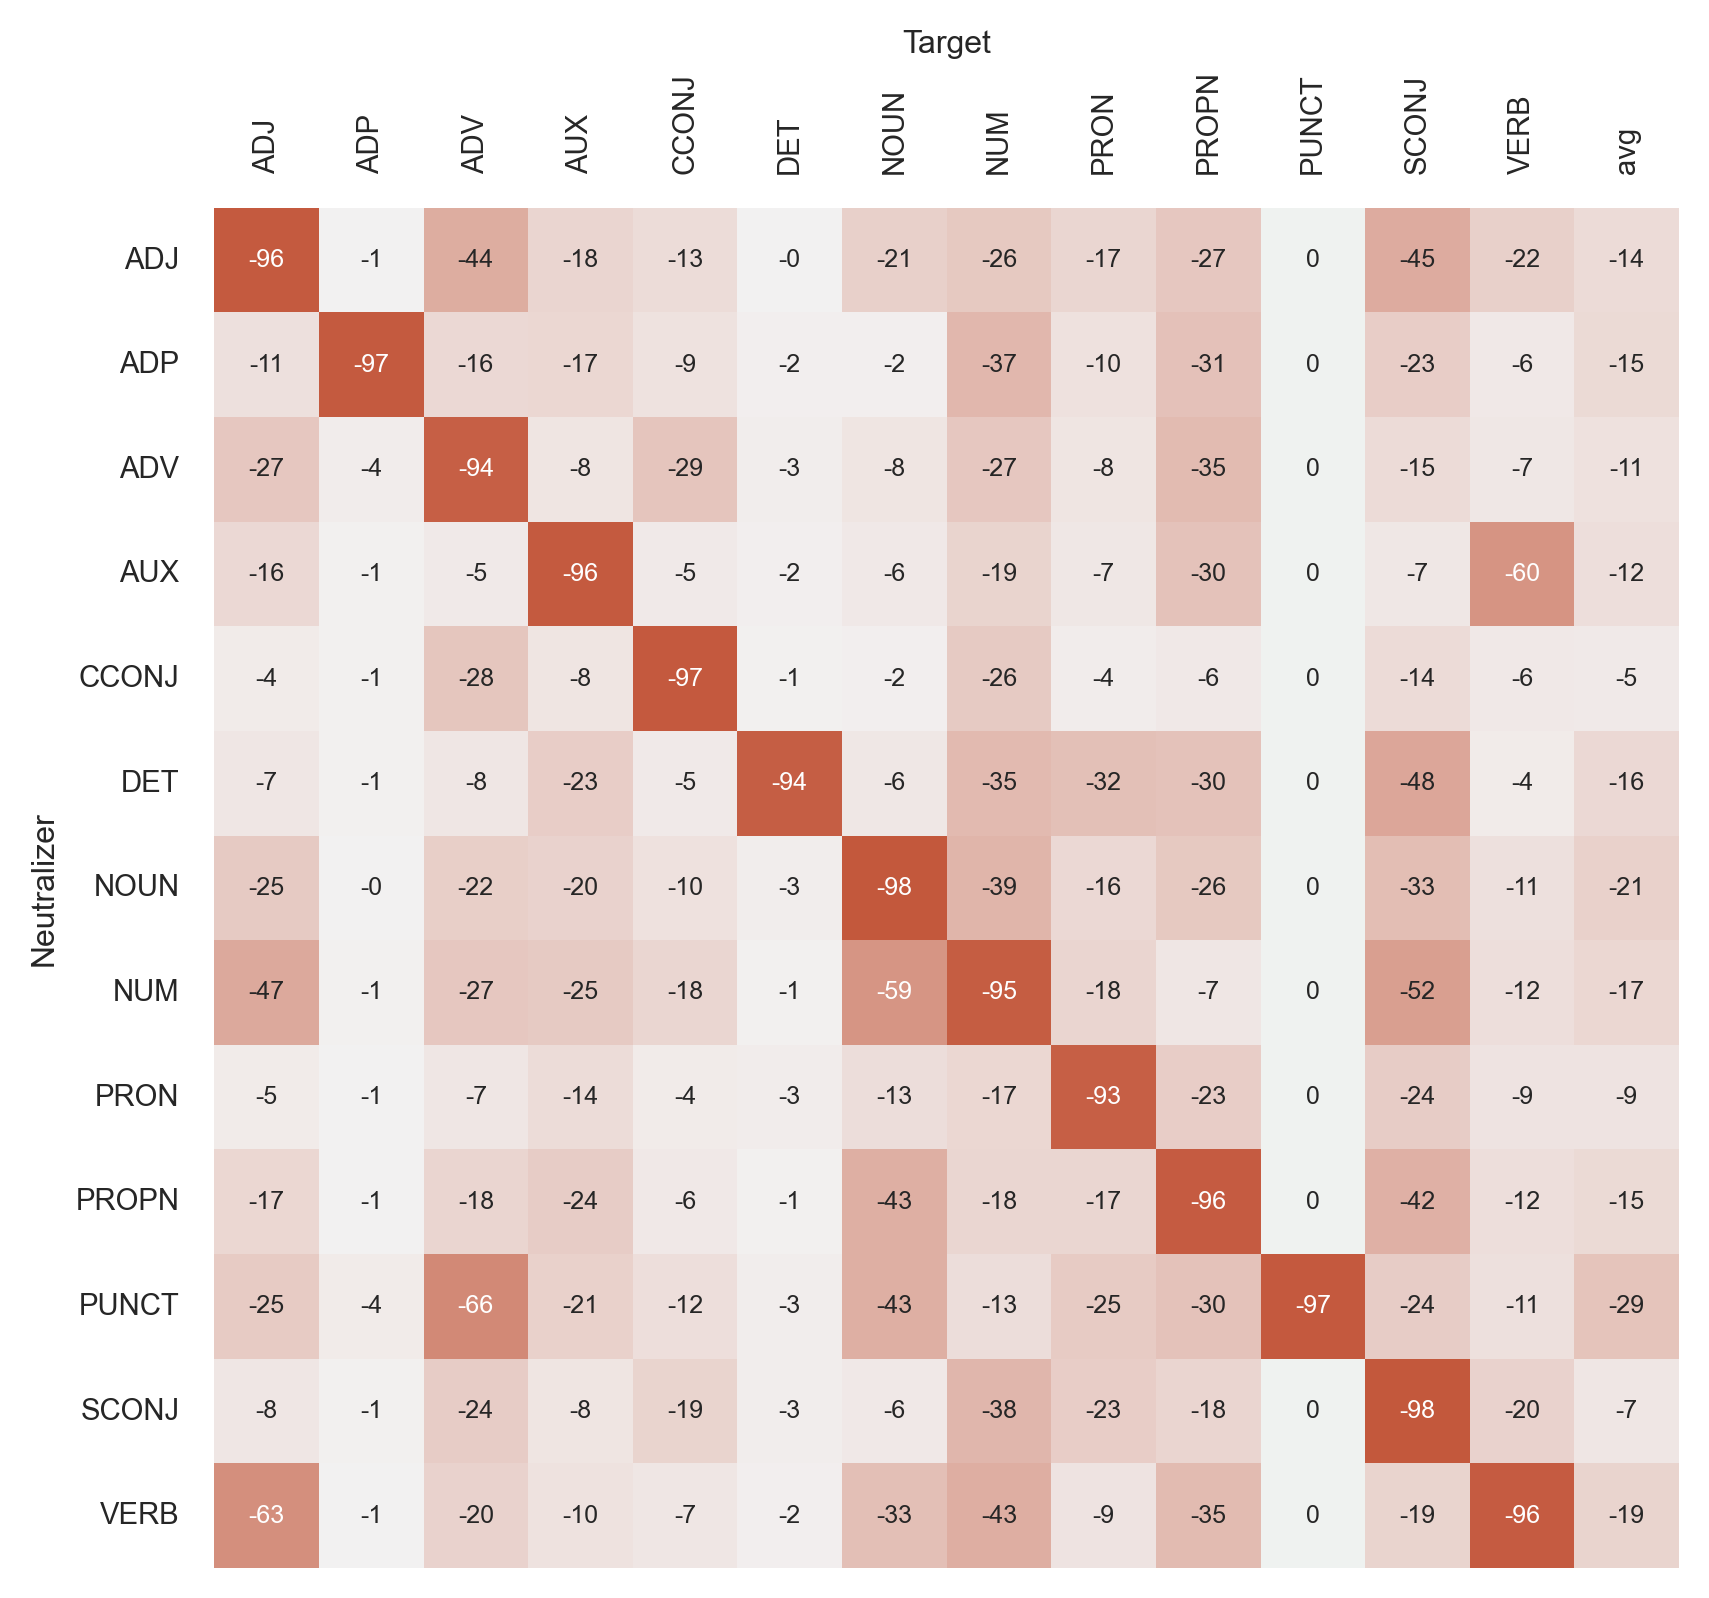

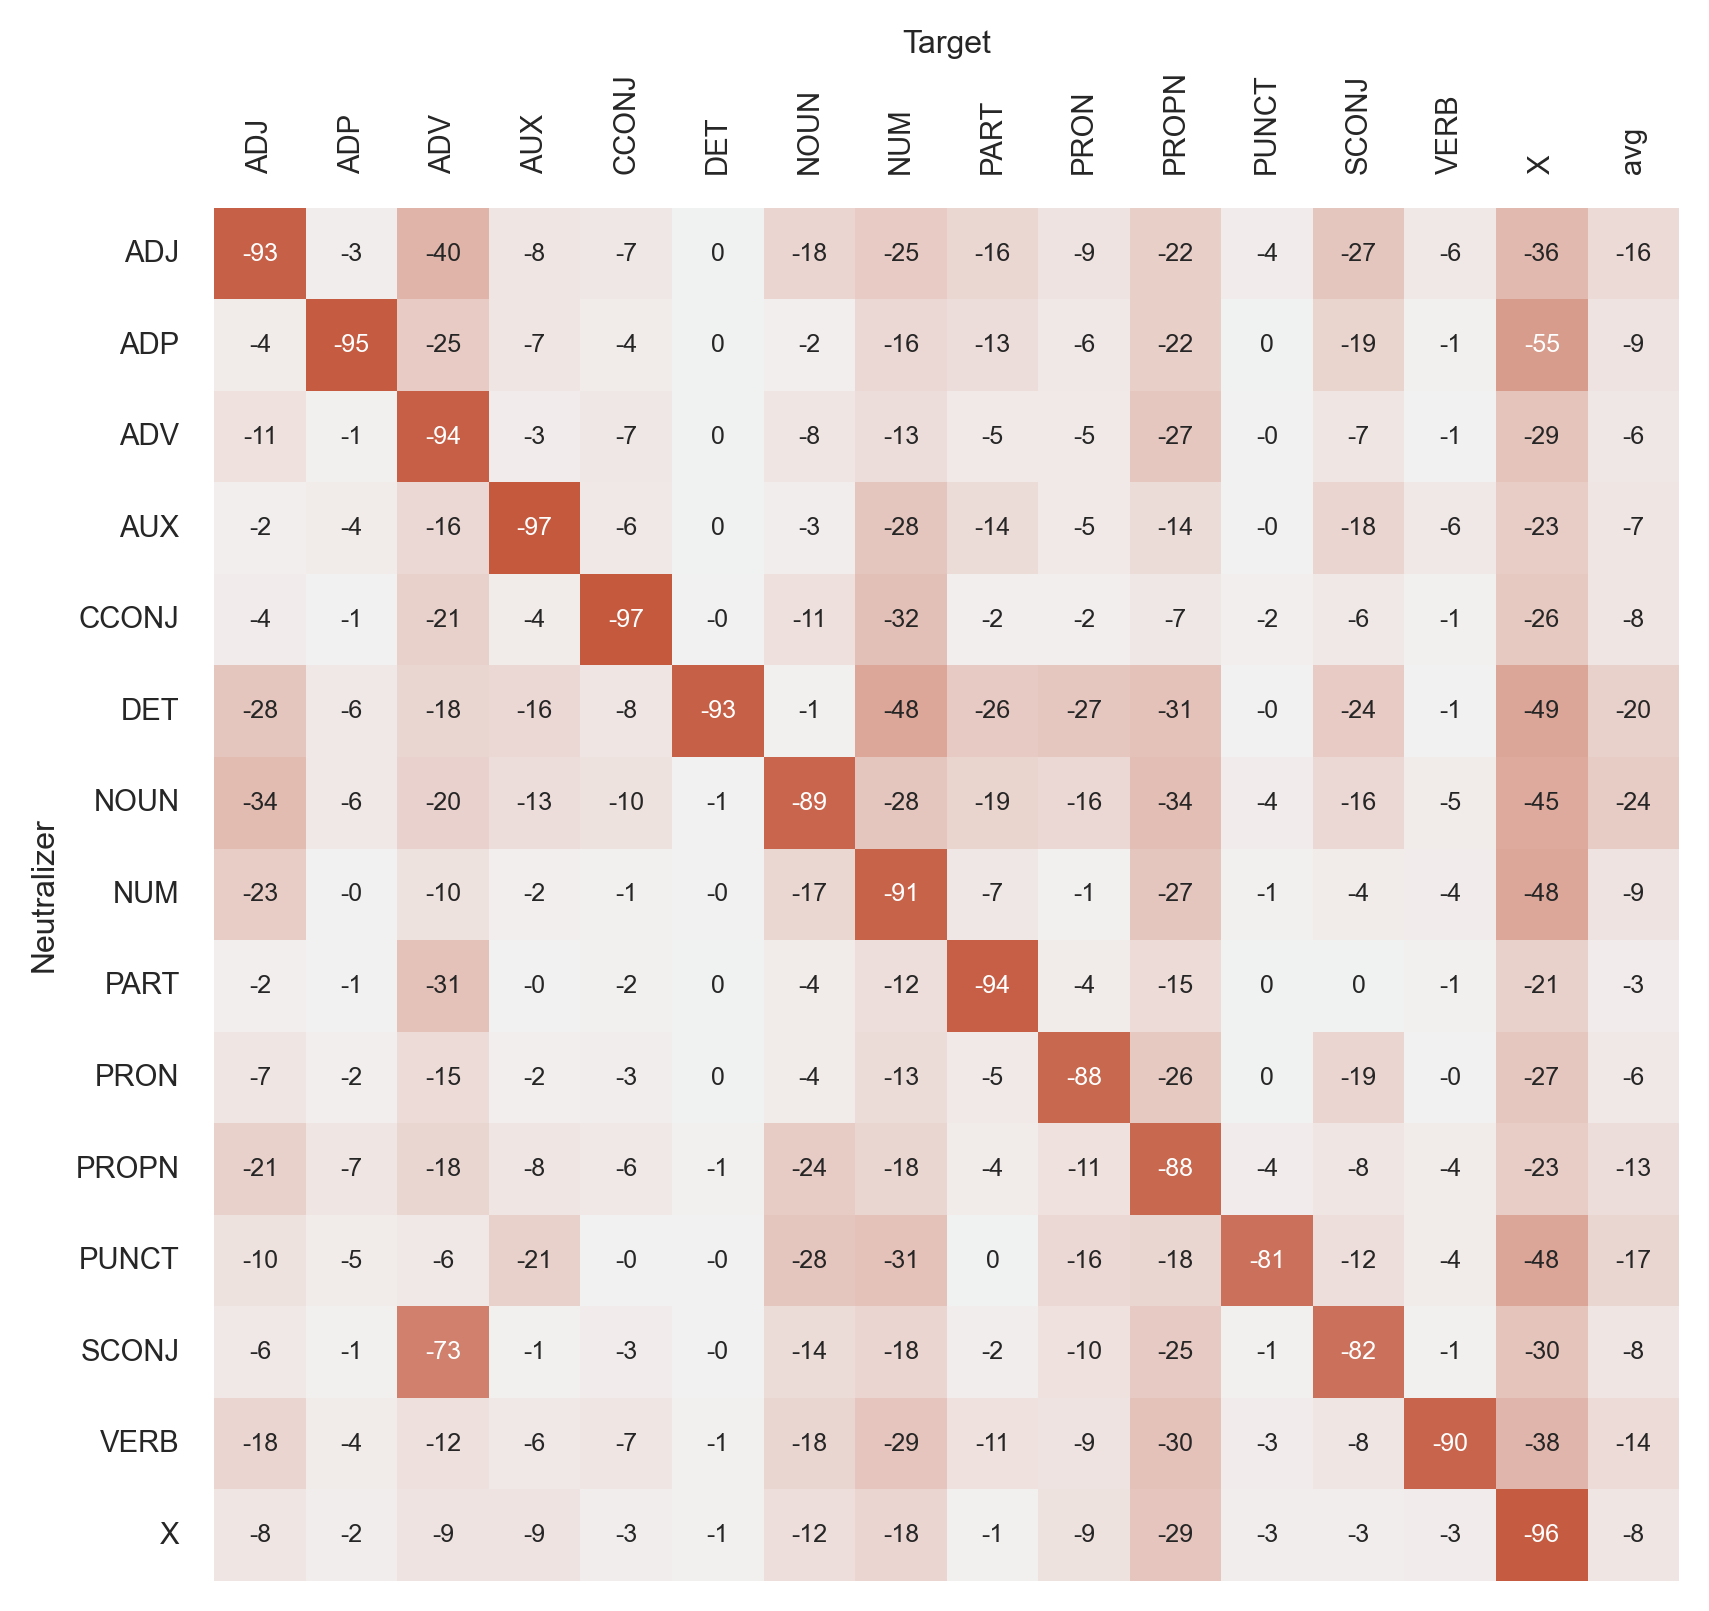

In [15]:
sns.set_context("paper", font_scale=0.8)
for i, (treebank, lang) in enumerate(lang_dict.items()):
    f, ax1 = plt.subplots(1, 1, figsize=(TEXTWIDTH, TEXTWIDTH), dpi=300)

    pos_acc_drop = lang["appendix"]

    ax1 = sns.heatmap(
        pos_acc_drop * 100,
        annot=True,
        annot_kws={"fontsize": 6},
        fmt=".0f",
        cmap=cmap,
        cbar=False,
        ax=ax1,
        vmin=-100,
        vmax=100,
        center=0,
        square=True,
    )
    ax1.tick_params(
        axis="x",
        which="major",
        top=False,
        labeltop=True,
        labelbottom=False,
        labelrotation=90,
    )
    ax1.xaxis.set_label_position("top")
    ax1.tick_params(
        axis="y",
        which="major",
        left=False,
        labelrotation=0,
    )
    plt.savefig(
        f"../images/final/pos-xn-xlm_r-{treebank}-appendix.eps", bbox_inches="tight"
    )
    plt.show()

## Cross-Lingual Cross-Neutralisation

Here we plot filtered cross-neutralization for the POS tasks when neutralising across language embeddings/centroids, all from XLM-R.

### Main Text

In [16]:
probing_config = {
    "en_gum_from_it_vit": {
        "POS": "agg=max_probe=9",
    },
    "en_gum_from_el_gdt": {
        "POS": "agg=max_probe=9",
    },
    "it_vit_from_en_gum": {
        "POS": "agg=first_probe=9",
    },
    "it_vit_from_el_gdt": {
        "POS": "agg=first_probe=9",
    },
    "el_gdt_from_en_gum": {
        "POS": "agg=max_probe=9",
    },
    "el_gdt_from_it_vit": {
        "POS": "agg=max_probe=9",
    },
}
treebank2lang = {"en_gum": "English", "it_vit": "Italian", "el_gdt": "Greek"}

In [17]:
treebank = "it_vit_from_en_gum"

In [18]:
# determining best probing layer and aggregation function
pos_experiments_df = utils.get_experiments_df(
    "POS", treebank, "xlm-roberta-base", "../lightning_logs"
)
pos_mode = probing_config[treebank]["POS"]

In [19]:
# use slightly different keep tags
KEEP_TAGS = {
    "POS": ["NOUN", "ADJ", "VERB", "PRON", "DET", "NUM", "ADV", "AUX"],
    "DEP": ["CONJ", "NSUBJ", "OBJ", "OBL", "ADVCL", "CASE", "DET", "AMOD"],
}

In [20]:
# computing accuracy drop due to neutralisation
pos_eval_path = f"../lightning_logs/xlm-roberta-base/{treebank}/POS/{pos_mode}/evaluation"
pos_acc_drop = utils.get_acc_drop(pos_eval_path, KEEP_TAGS["POS"])

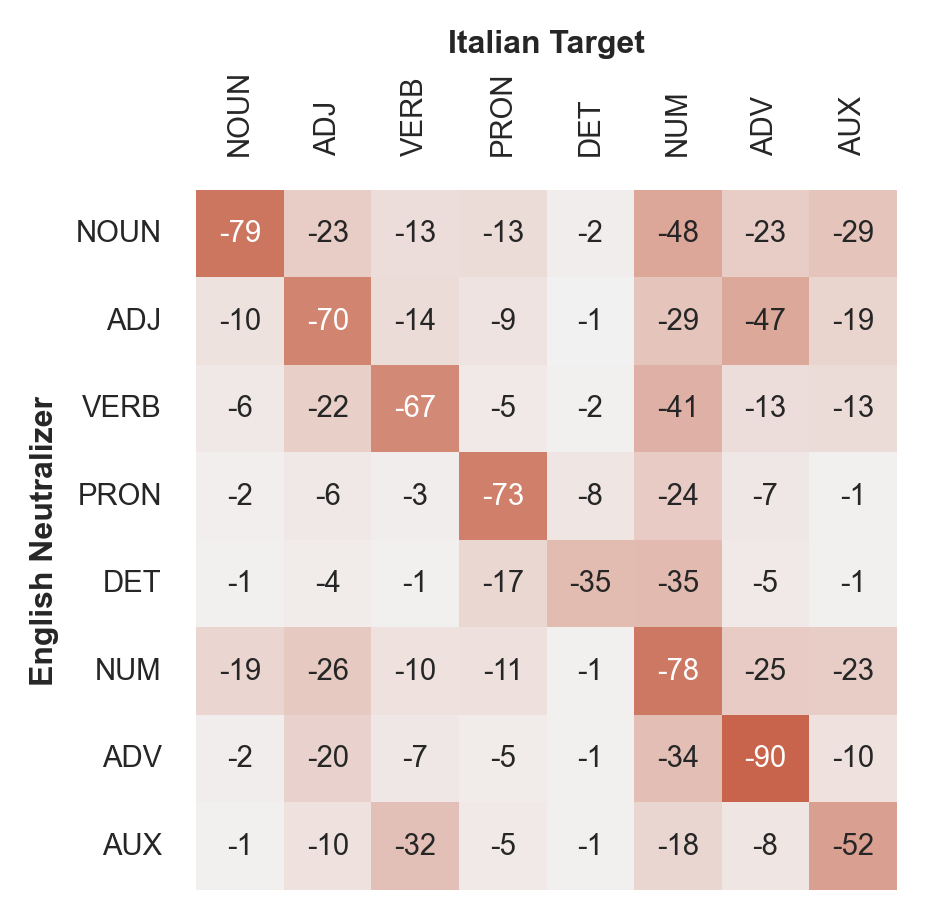

In [21]:
# plot
sns.set_context("paper", font_scale=0.8)
f, ax1 = plt.subplots(1, 1, figsize=(COLWIDTH, COLWIDTH), dpi=300)
ax1 = sns.heatmap(
    pos_acc_drop * 100,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0f",
    cmap=cmap,
    cbar=False,
    ax=ax1,
    vmin=-100,
    vmax=100,
    center=0,
    square=True,
)
ax1.set_xlabel("Italian " + ax1.get_xlabel(), fontdict=label_dict)
ax1.xaxis.set_label_position("top")
ax1.set_ylabel("English " + ax1.get_ylabel(), fontdict=label_dict)
ax1.tick_params(
    axis="x",
    which="major",
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    labelrotation=90,
)
ax1.tick_params(
    axis="y",
    which="major",
    left=False,
    labelrotation=0,
)

plt.savefig(
    f"../images/final/pos-xl-xn-main.eps", bbox_inches="tight"
)
plt.show()

### Appendix

We now plot the complete (not sampling) X-Lingual X-Neutralisation for each combination, to place them in the report

In [22]:
# re-usable plotting function
def plot_heatmap(
    df,
    neutralizer,
    target,
    save_name=None,
    vmin=None,
    vmax=None,
    center=0.0,
    cbar=True,
    annot_kws={"fontsize": 7},
):
    bold = {"weight": "bold"}

    plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH), dpi=300)
    cmap = sns.diverging_palette(20, 145, as_cmap=True)
    ax = sns.heatmap(
        df * 100,
        annot=True,
        fmt=".0f",
        cmap=cmap,
        cbar=cbar,
        vmin=vmin,
        vmax=vmax,
        center=center,
        square=True,
        annot_kws=annot_kws,
    )
    ax.set_xlabel(target + " " + ax.get_xlabel(), fontdict=bold)
    ax.tick_params(
        axis="x",
        which="major",
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
        labelrotation=90,
    )
    ax.xaxis.set_label_position("top")

    ax.tick_params(
        axis="y",
        which="major",
        left=False,
        labelrotation=0,
    )
    ax.set_ylabel(neutralizer + " " + ax.get_ylabel(), fontdict=bold)

    if save_name:
        plt.savefig(save_name, bbox_inches="tight")
    plt.show()

POS en_gum_from_it_vit


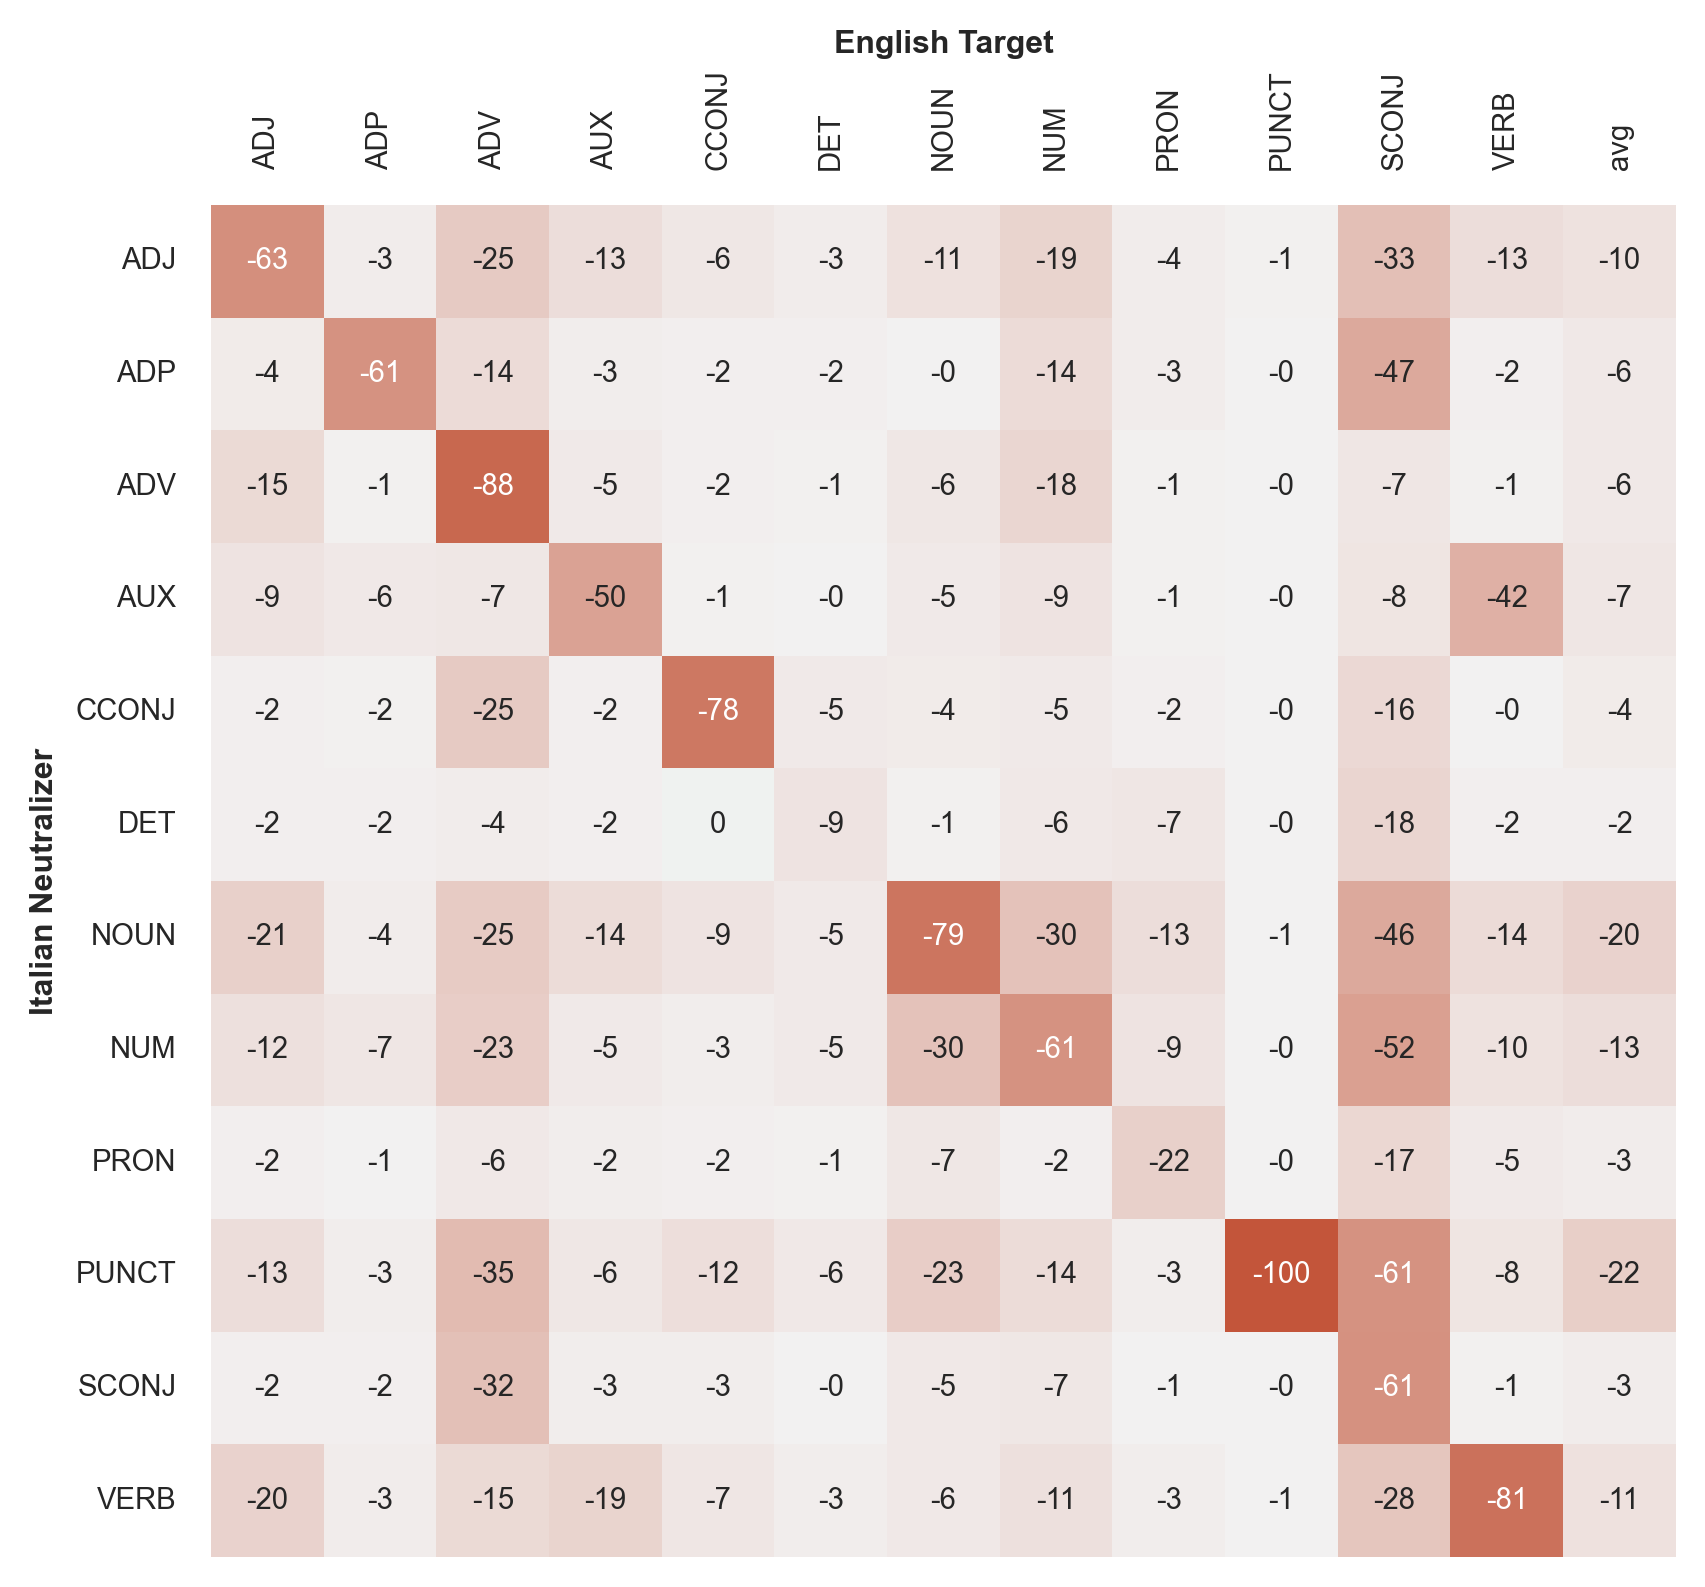

POS en_gum_from_el_gdt


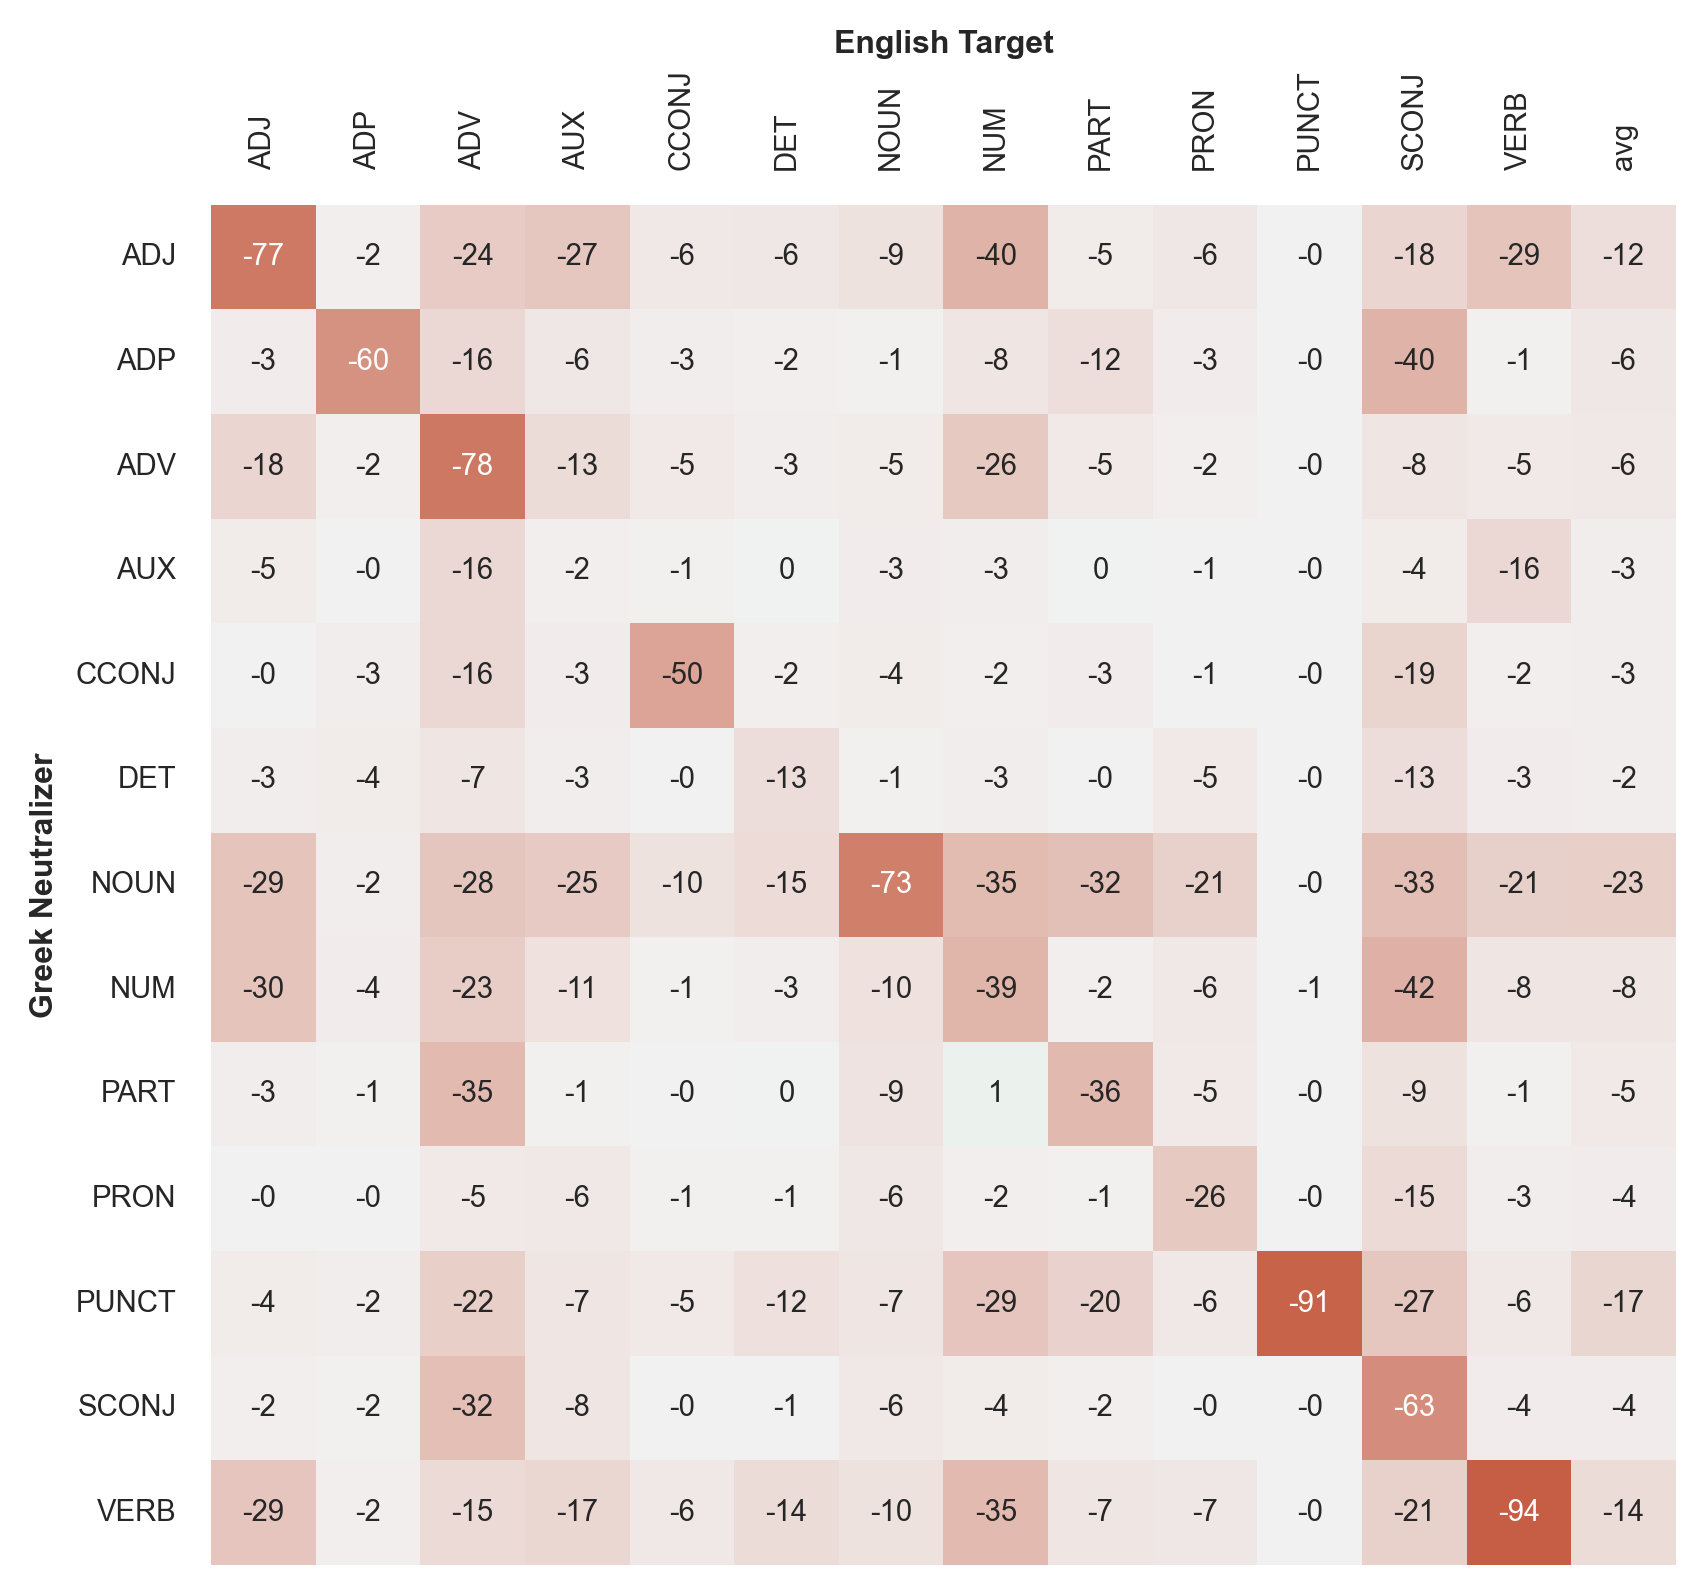

POS it_vit_from_en_gum


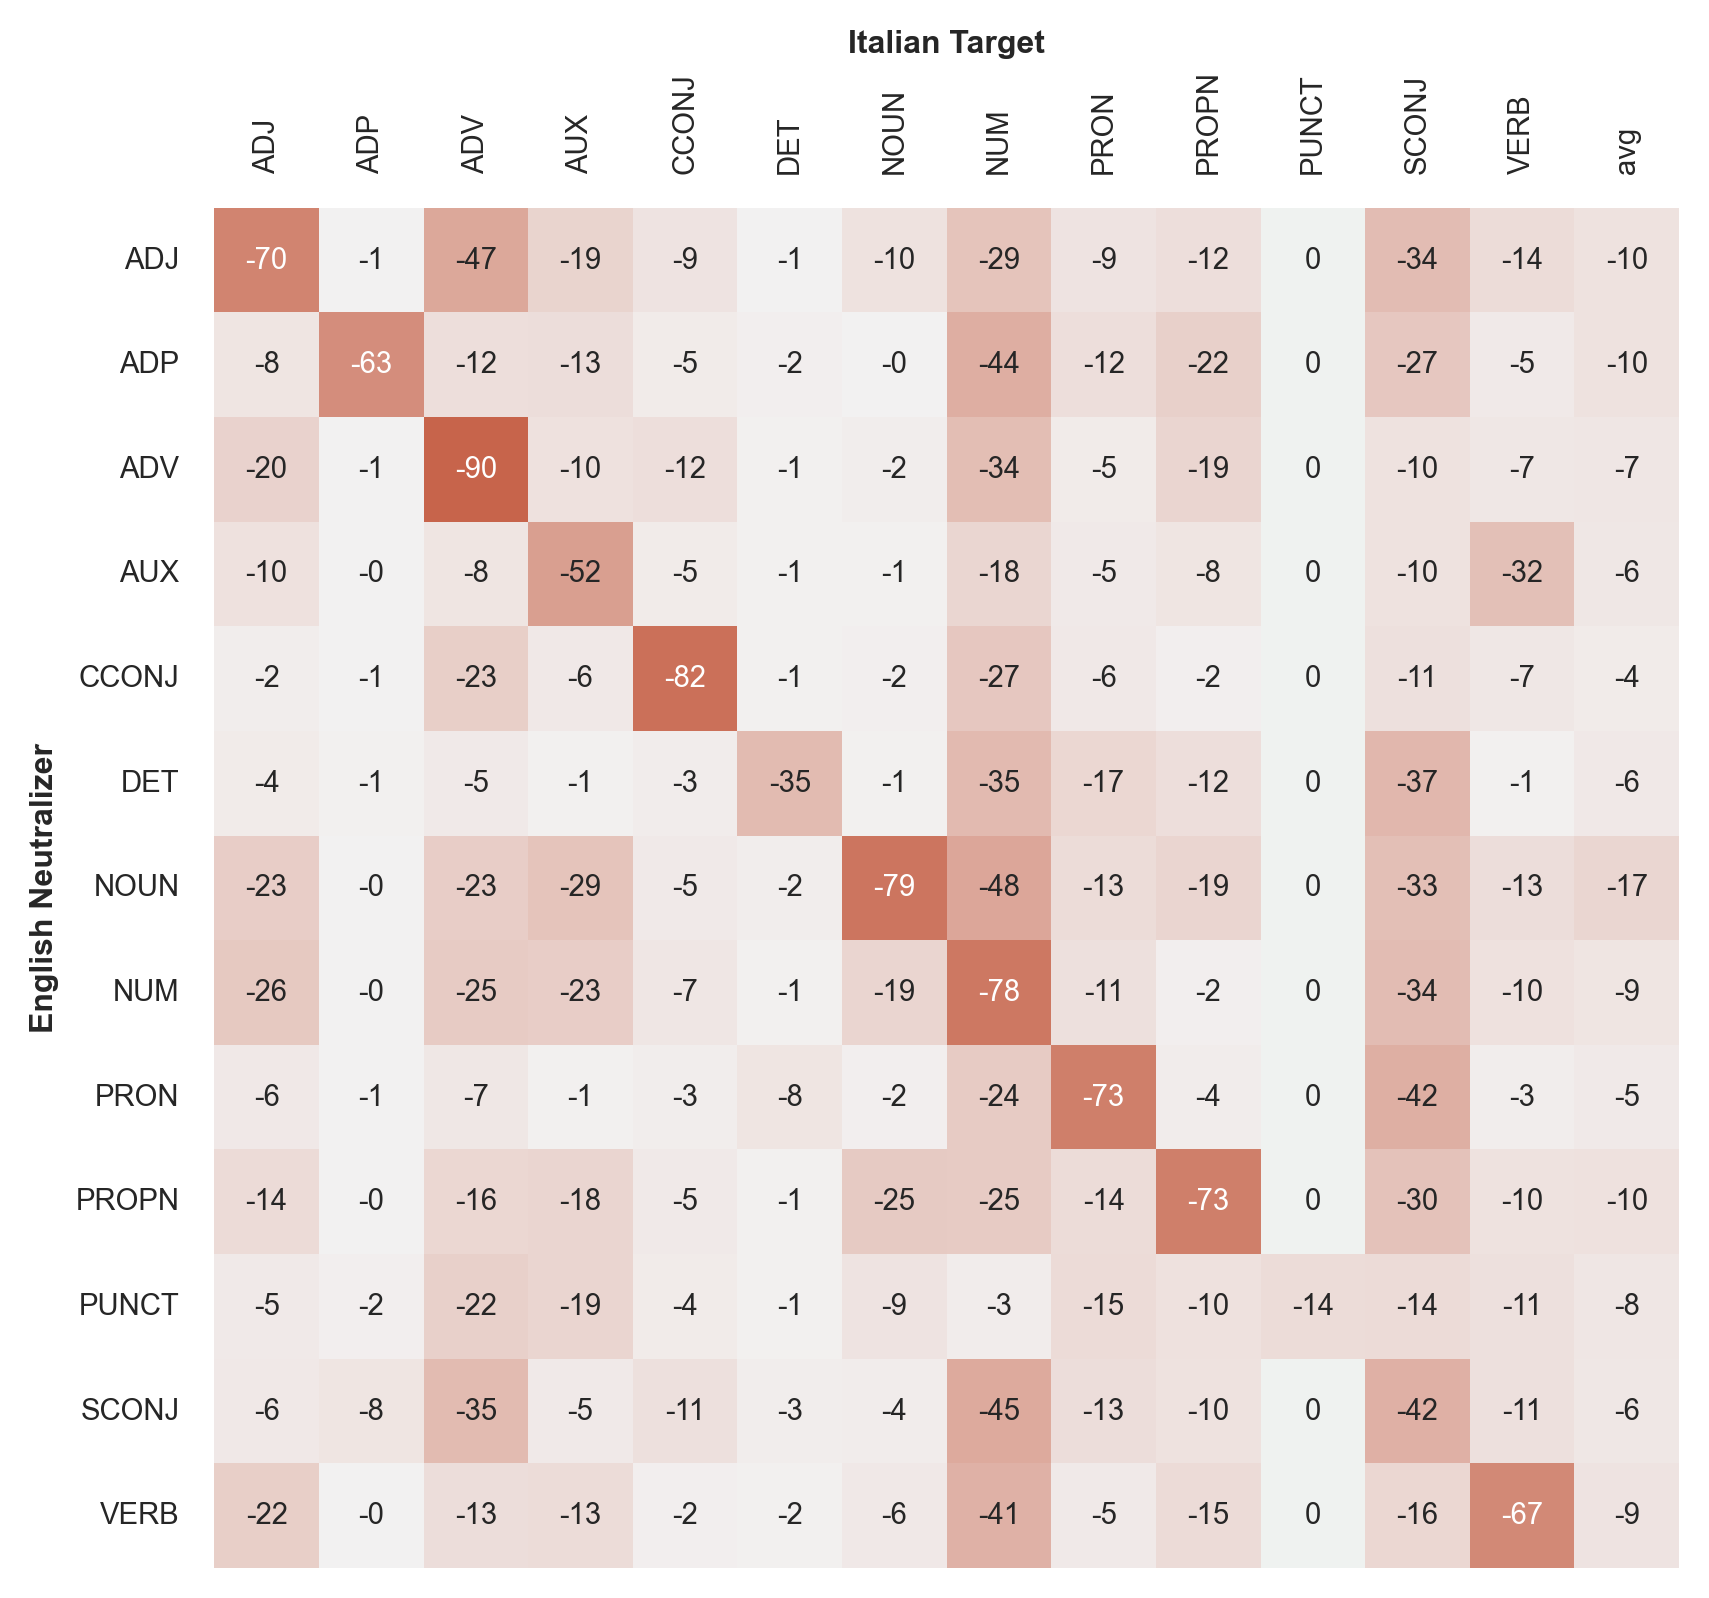

POS it_vit_from_el_gdt


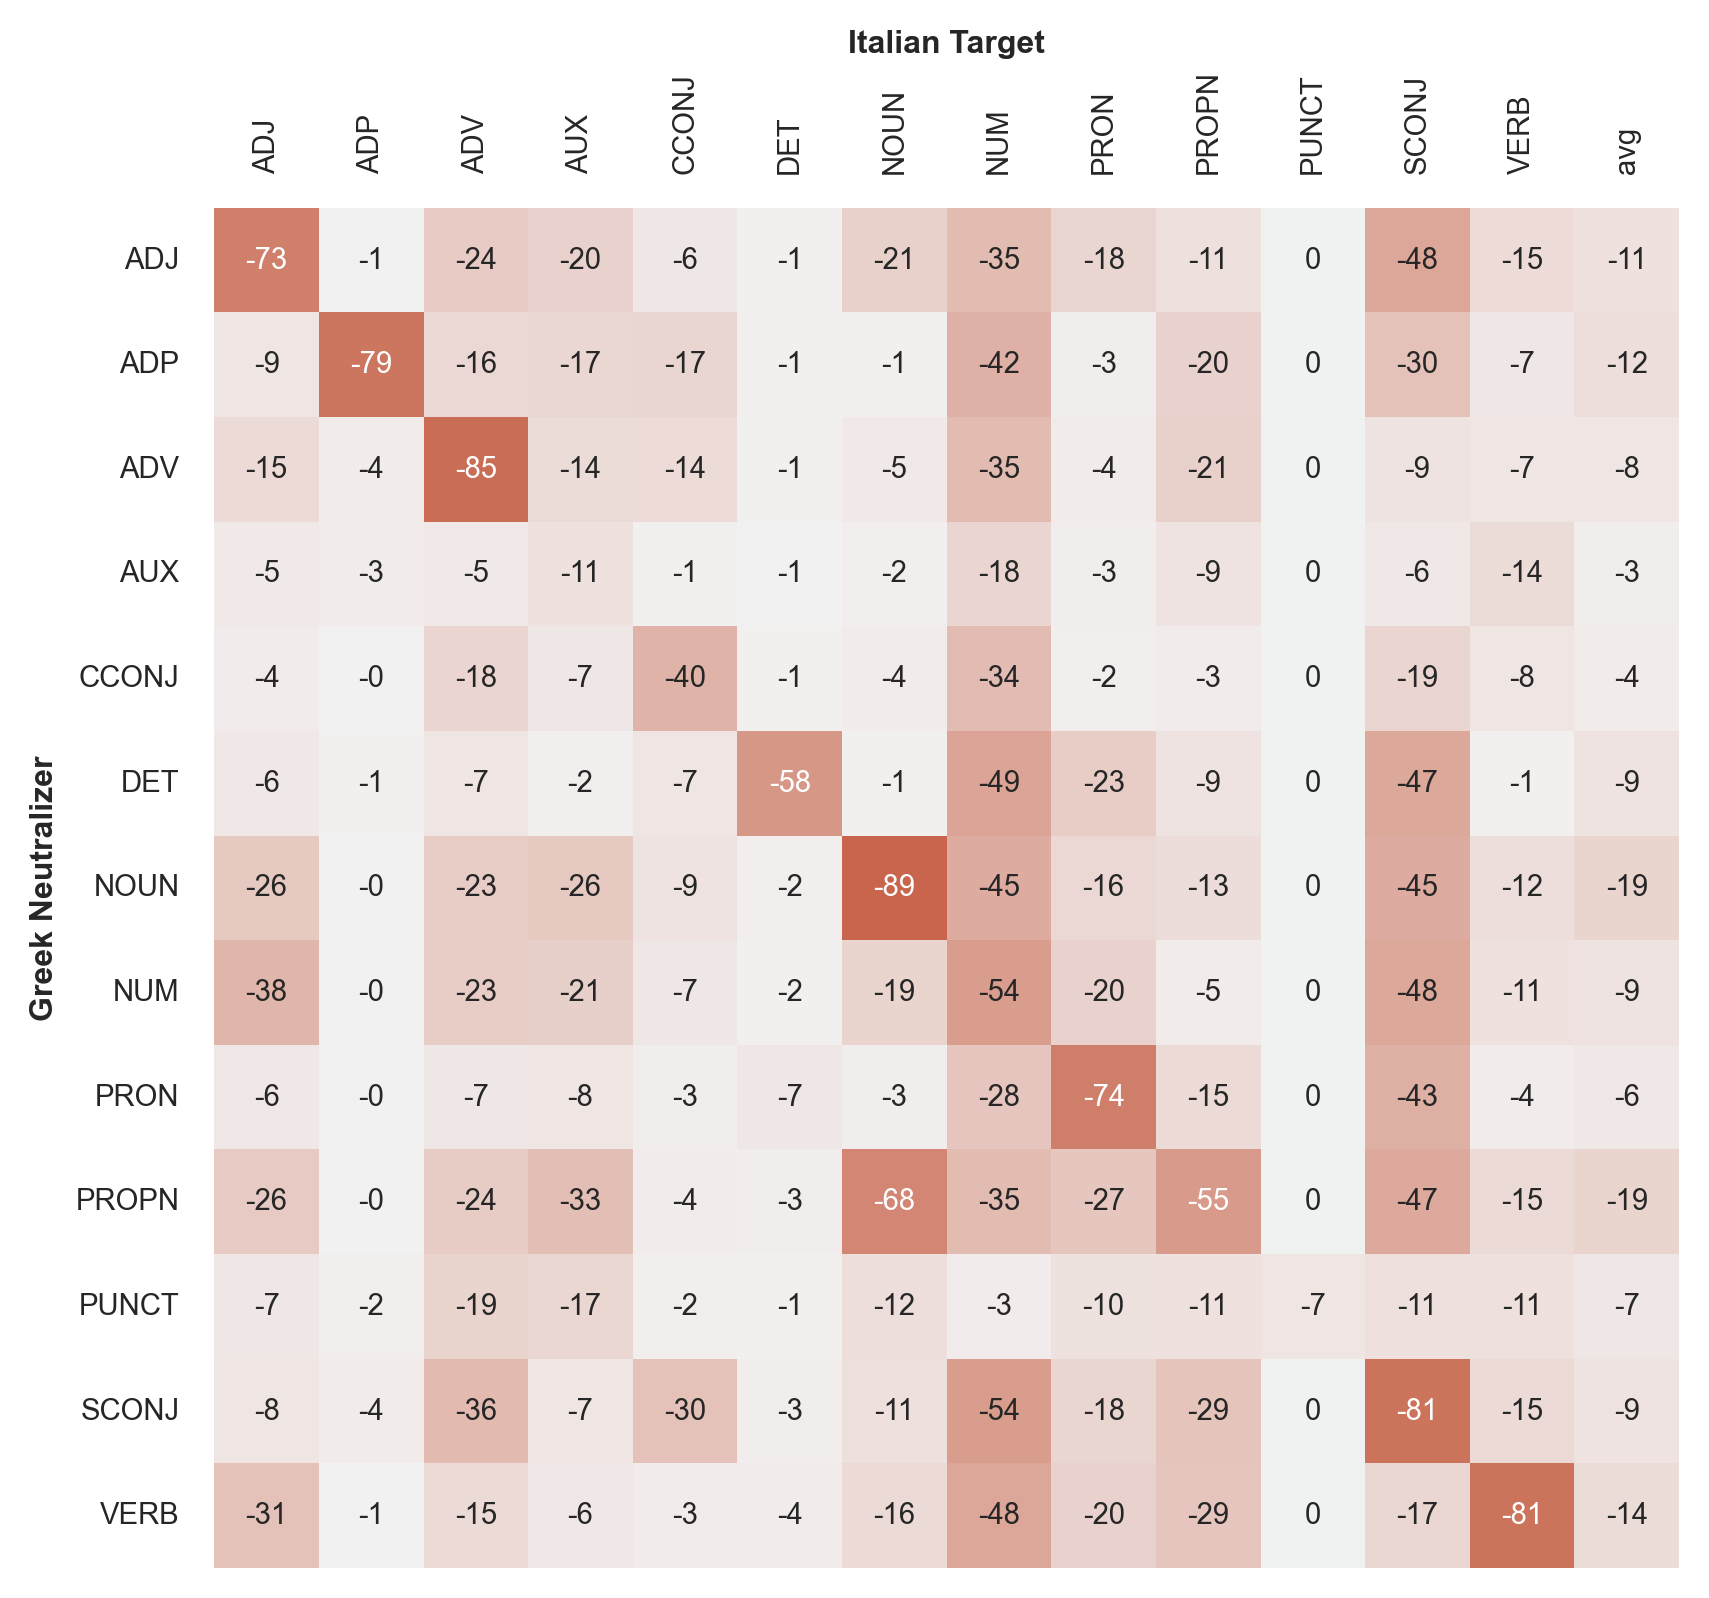

POS el_gdt_from_en_gum


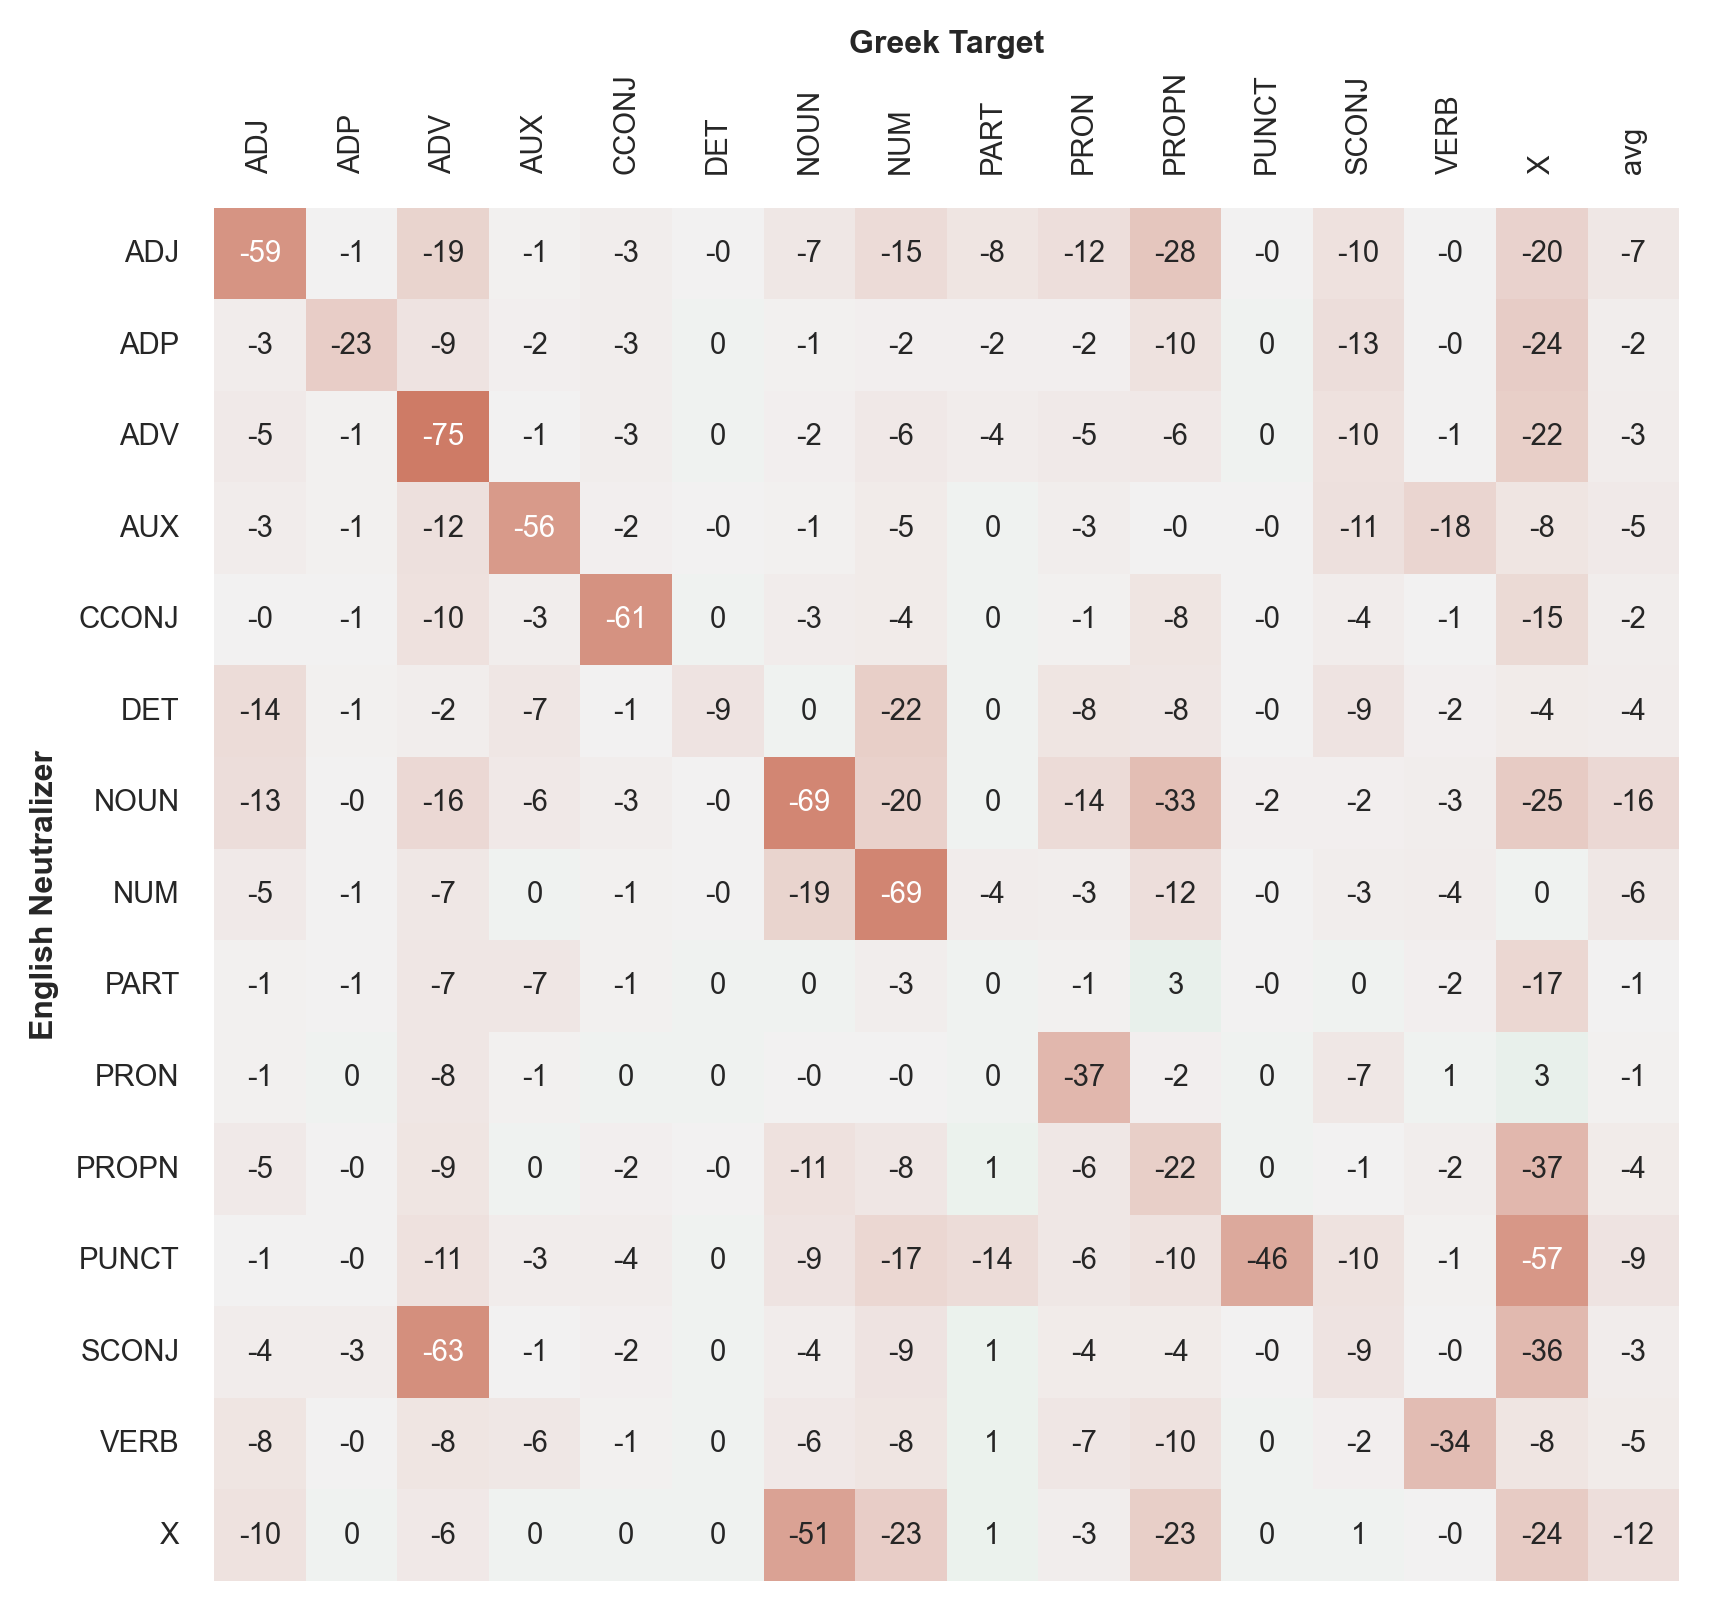

POS el_gdt_from_it_vit


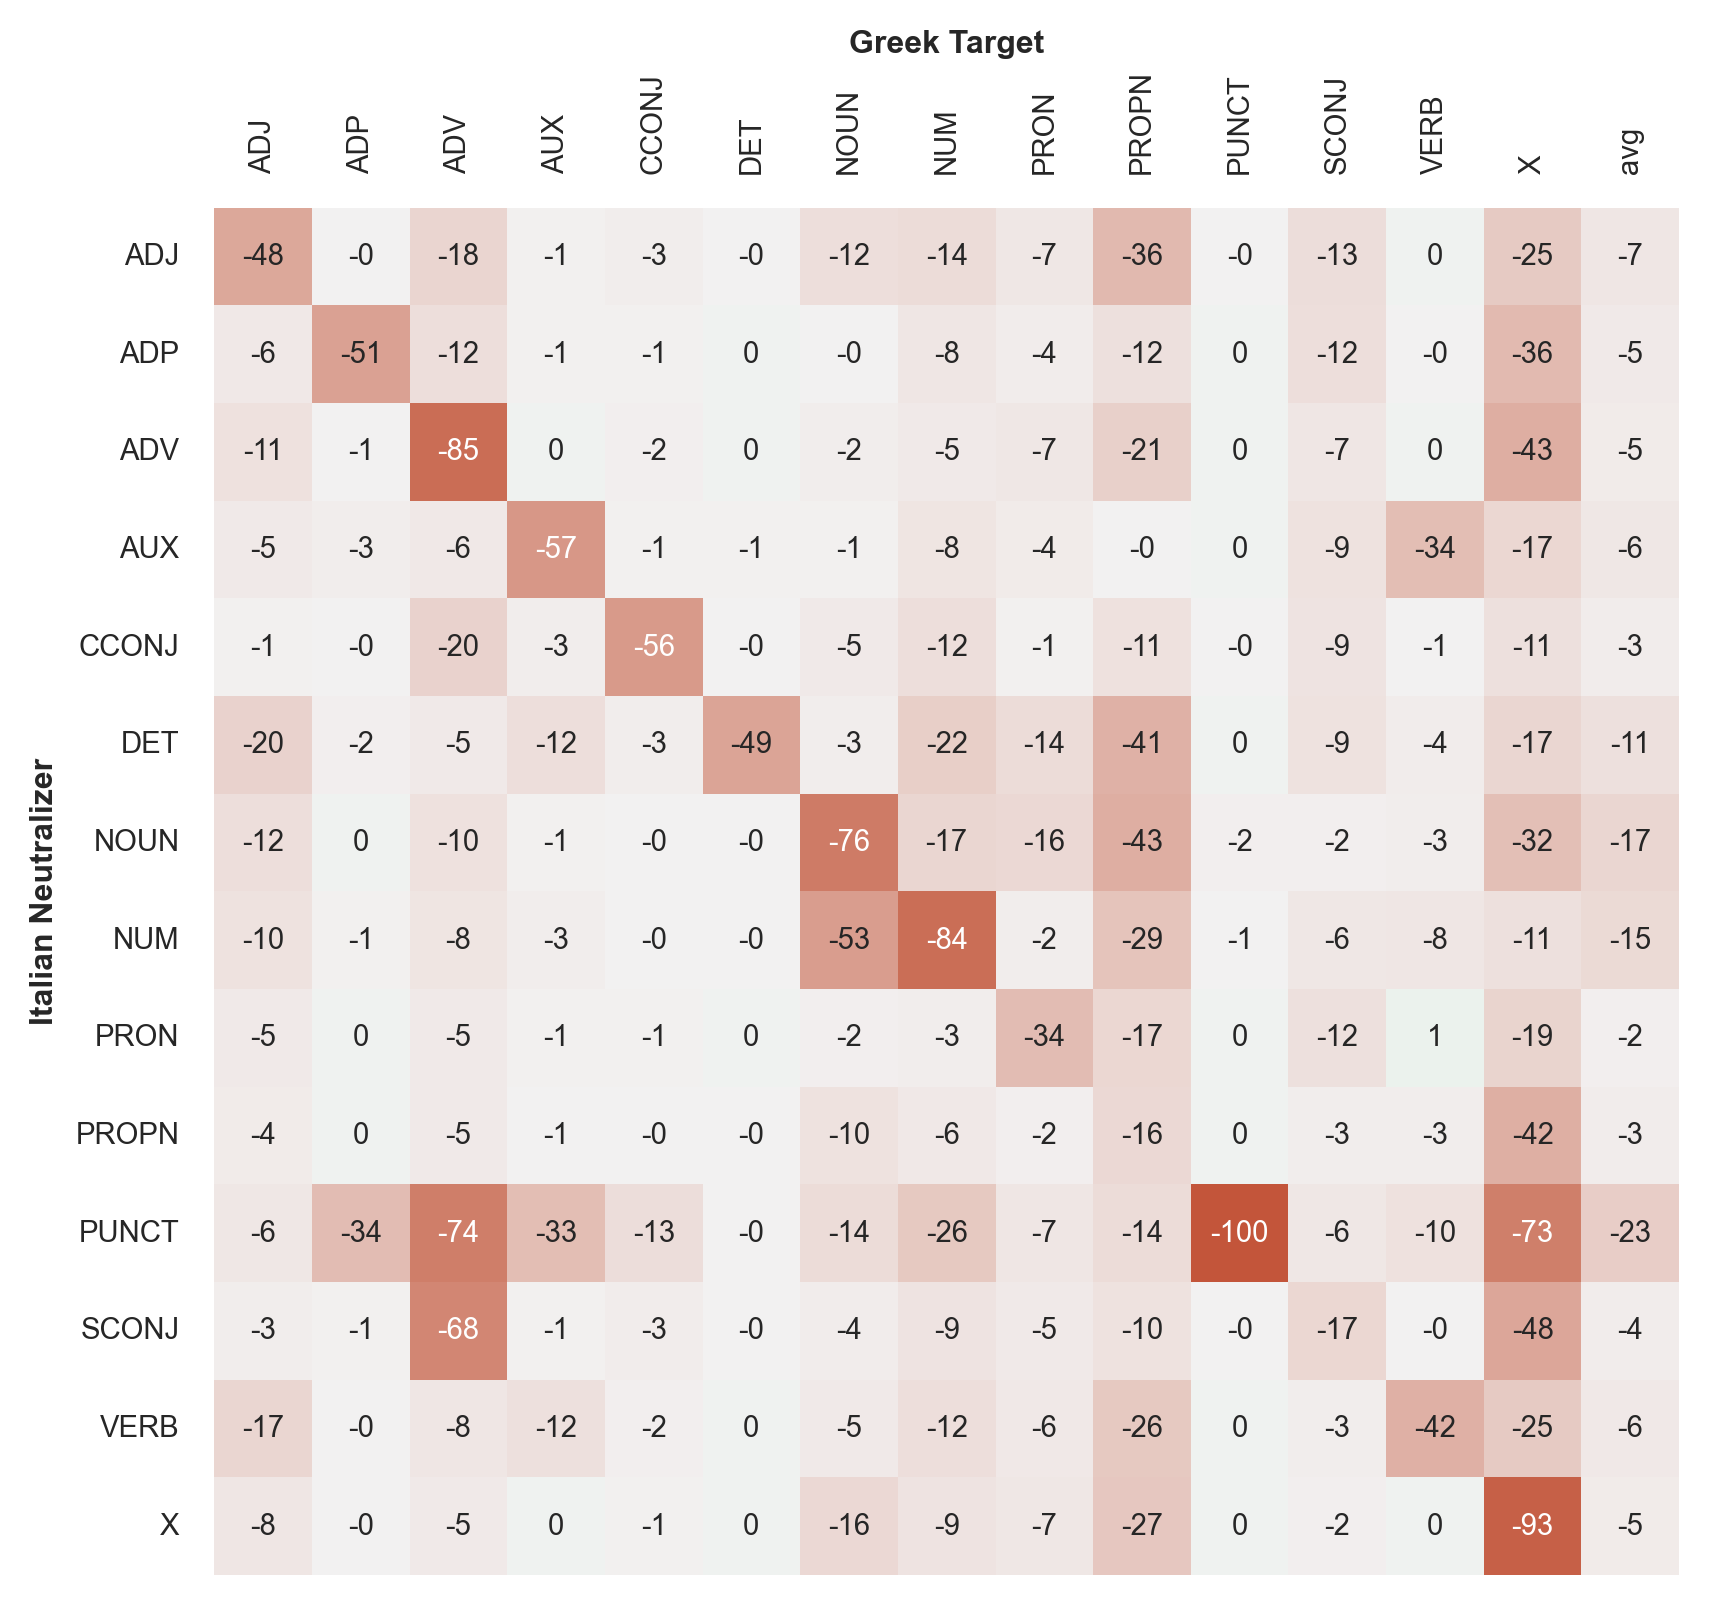

In [23]:
for treebank in probing_config.keys():
    target_tb, neutralizer_tb = treebank.split("_from_")
    target = treebank2lang[target_tb]
    neutralizer = treebank2lang[neutralizer_tb]
    for task in ["POS"]:
        print(task, treebank)
        experiments_df = utils.get_experiments_df(
            task, treebank, "xlm-roberta-base", "../lightning_logs/"
        )
        mode = probing_config[treebank][task]
        eval_path = (
            f"../lightning_logs/xlm-roberta-base/{treebank}/{task}/{mode}/evaluation"
        )
        acc_drop = utils.get_acc_drop(eval_path, None)
        plot_heatmap(
            acc_drop,
            neutralizer,
            target,
            save_name=f"../images/final/{task}-xl-xn-{treebank}-appendix.eps",
            vmin=-100,
            vmax=100,
            cbar=False,
        )

## Cross-task Cross-Neutralisation

We now plot the cross-task cross neutralisation performed with RoBERTa and XLM-R embeddings

### RoBERTa

In [24]:
pos_eval_path = f"../lightning_logs/roberta-base/en_gum/POS/agg=max_probe=3/evaluation"
pos_acc_drop = utils.get_acc_drop(pos_eval_path, None, suffix_filter=r"^([a-z]+)$")

dep_eval_path = f"../lightning_logs/roberta-base/en_gum/DEP/agg=mean_probe=3_concat-mode=ONLY/evaluation"
dep_acc_drop = utils.get_acc_drop(dep_eval_path, None, suffix_filter=r"^([A-Z]+)$")

#### Main Text


In [25]:
keep_pos_neutr = [
    "ADV",
    "ADJ",
    "AUX",
    "DET",
    "ADP",
    "VERB",
    "CCONJ",
    "NOUN",
    "PRON",
    "SCONJ",
]
keep_dep_targs = [
    "ADVMOD",
    "AMOD",
    "AUX",
    "DET",
    "CASE",
    "ADVCL",
    "CC",
    "COP",
    "OBJ",
    "NSUBJ",
]
dep_acc_drop_main = (dep_acc_drop.loc[keep_pos_neutr])[keep_dep_targs]

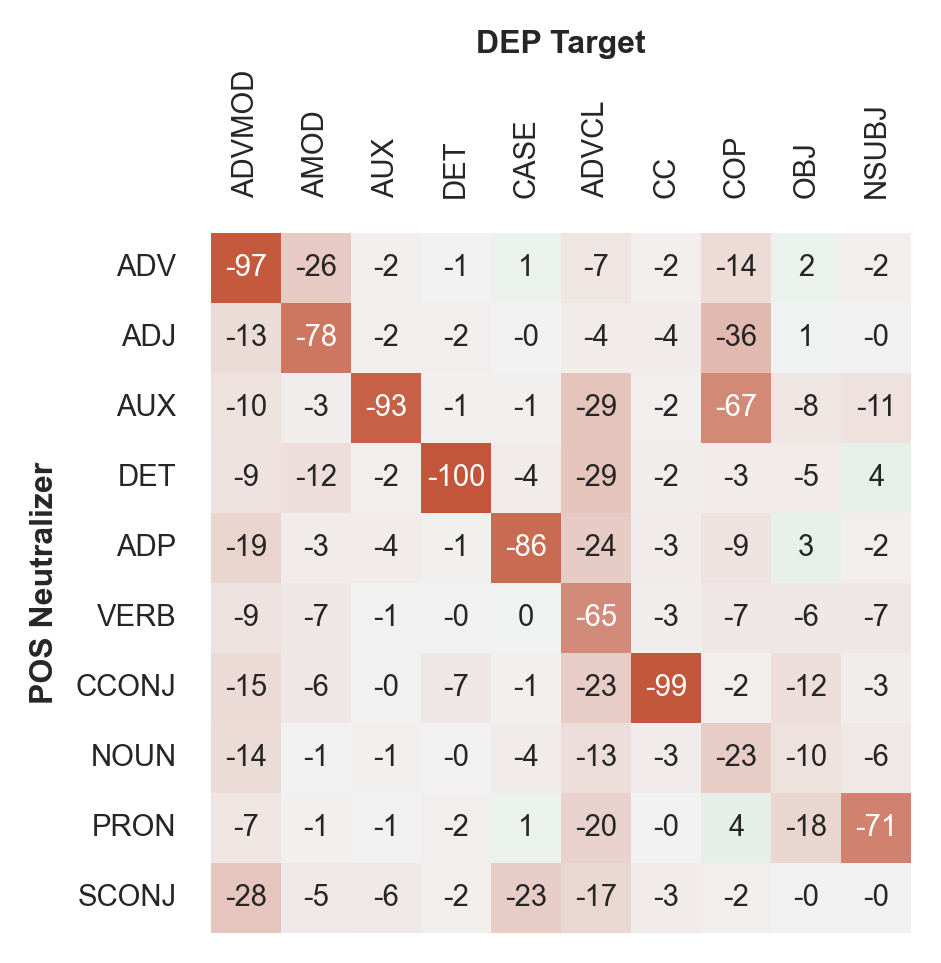

In [26]:
f, ax = plt.subplots(1,1, figsize=(COLWIDTH, COLWIDTH), dpi=300)

ax = sns.heatmap(
    dep_acc_drop_main * 100,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0f",
    cmap=cmap,
    cbar=False,
    ax=ax,
    vmin=-100,
    vmax=100,
    center=0,
    square=True,
)

ax.set_ylabel("POS " + ax.get_ylabel(), fontdict=label_dict)
ax.set_xlabel("DEP " + ax.get_xlabel(), fontdict=label_dict)
ax.tick_params(
    axis="x",
    which="major",
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    labelrotation=90,
)
ax.xaxis.set_label_position("top")
plt.savefig("../images/final/dep-xt-xn-posneutr-main.eps", bbox_inches="tight")
plt.show()

#### Appendix


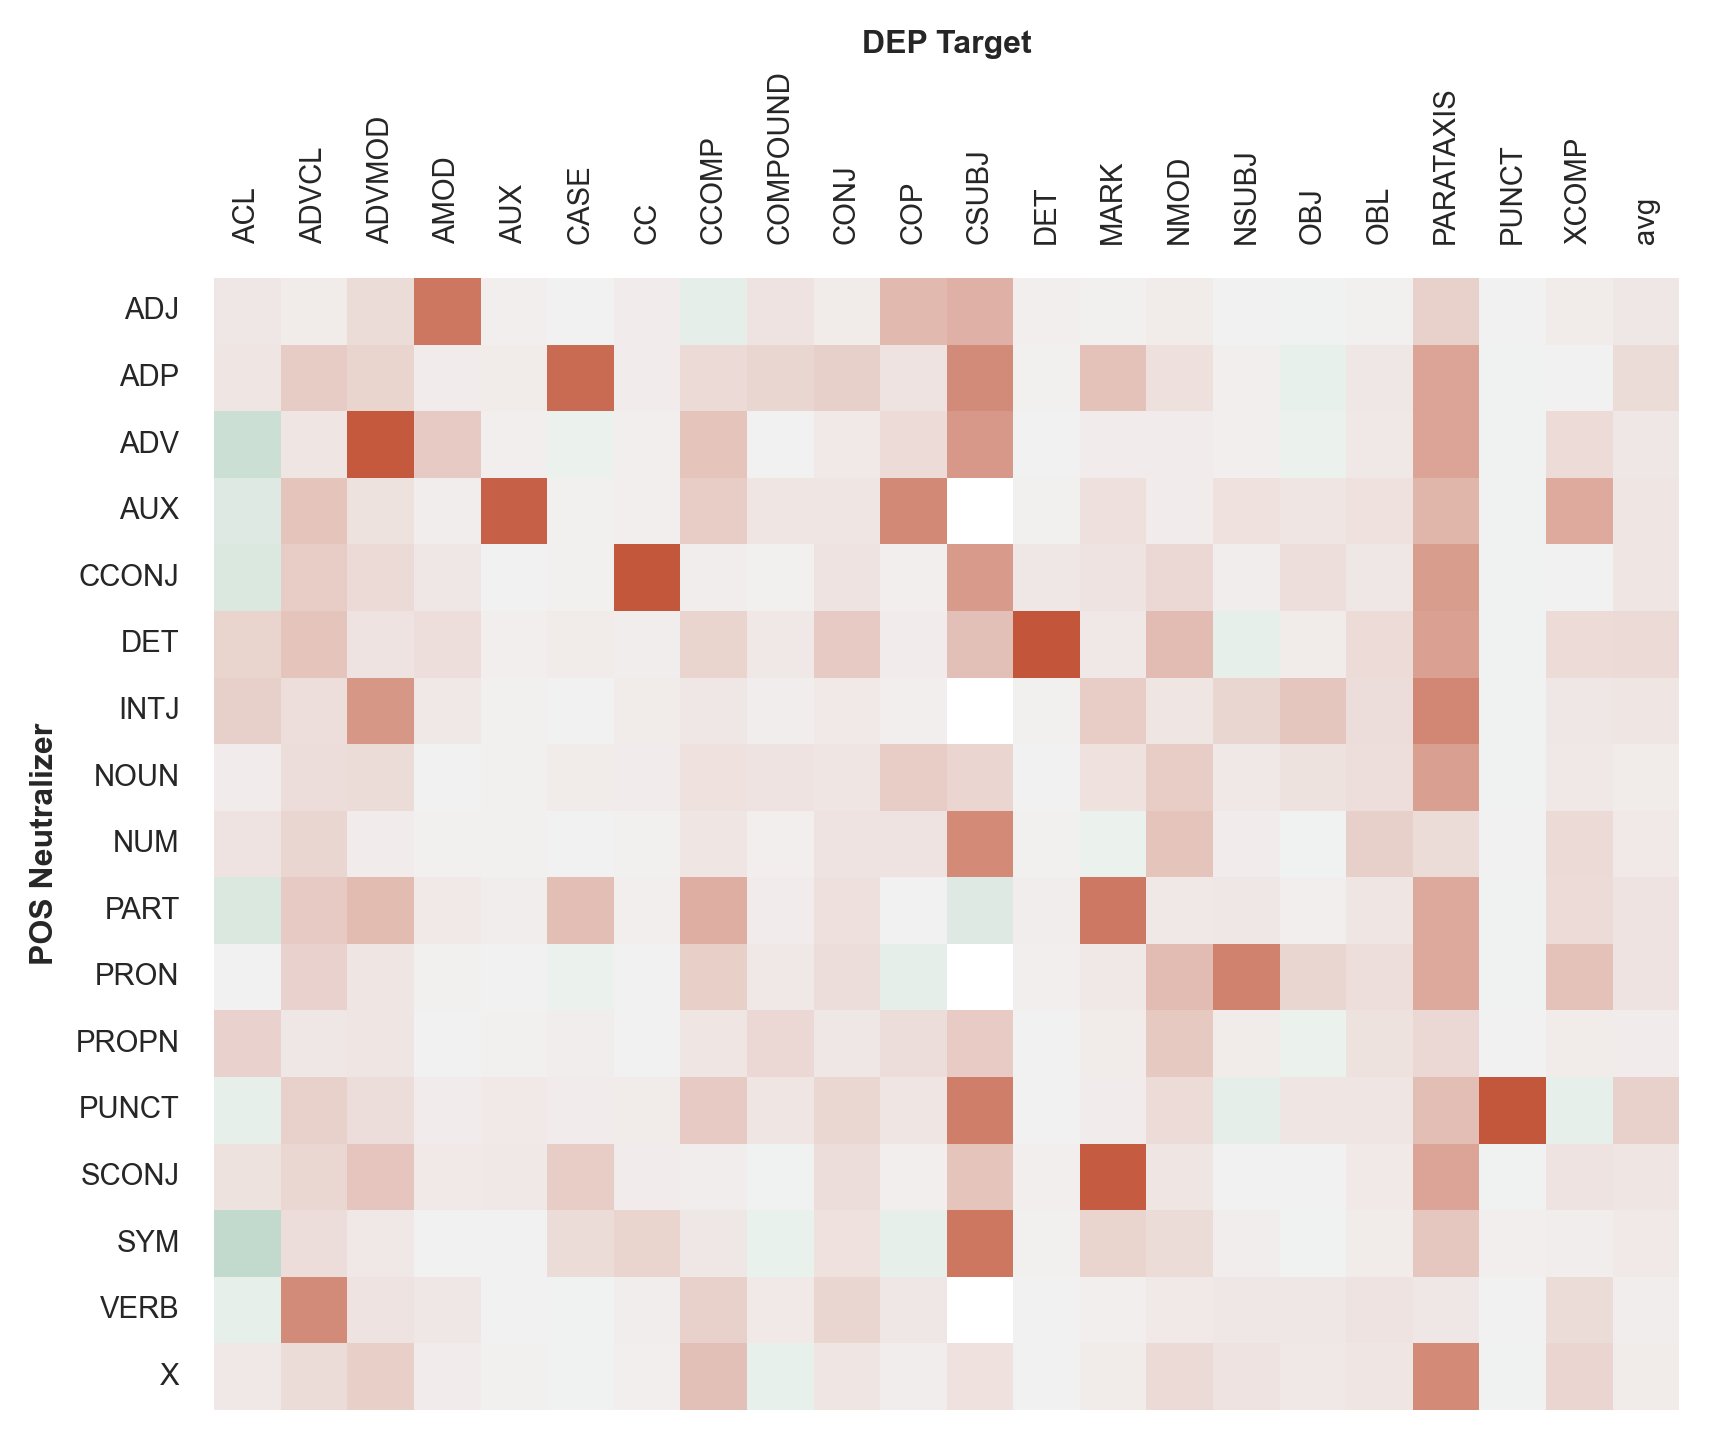

In [27]:
f, ax = plt.subplots(1,1, figsize=(TEXTWIDTH, TEXTWIDTH), dpi=300)

ax = sns.heatmap(
    dep_acc_drop * 100,
    annot=False,
    annot_kws={"fontsize": 7},
    fmt=".0f",
    cmap=cmap,
    cbar=False,
    ax=ax,
    vmin=-100,
    vmax=100,
    center=0,
    square=True,
)

ax.set_ylabel("POS " + ax.get_ylabel(), fontdict=label_dict)
ax.set_xlabel("DEP " + ax.get_xlabel(), fontdict=label_dict)
ax.tick_params(
    axis="x",
    which="major",
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    labelrotation=90,
)
ax.xaxis.set_label_position("top")
plt.savefig("../images/final/dep-xt-xn-posneutr-appendix.eps", bbox_inches="tight")
plt.show()

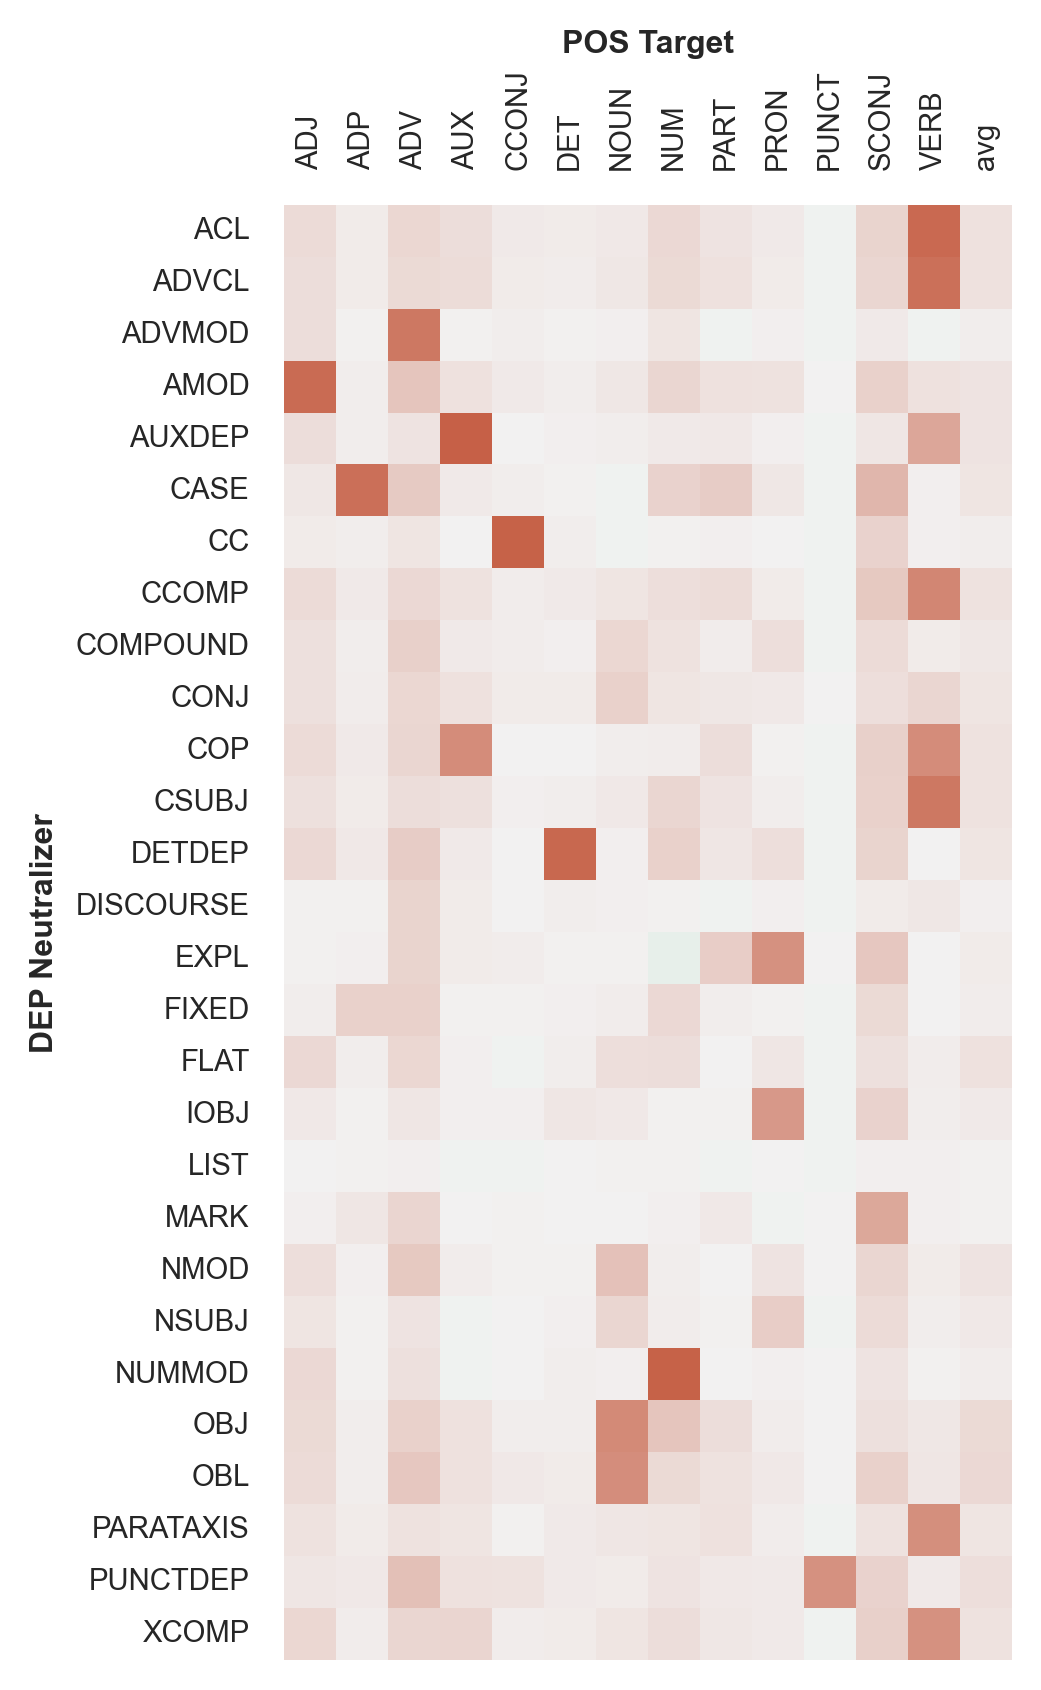

In [28]:
f, ax = plt.subplots(1,1, figsize=(TEXTWIDTH, TEXTWIDTH), dpi=300)

ax = sns.heatmap(
    pos_acc_drop * 100,
    annot=False,
    annot_kws={"fontsize": 7},
    fmt=".0f",
    cmap=cmap,
    cbar=False,
    ax=ax,
    vmin=-100,
    vmax=100,
    center=0,
    square=True,
)

ax.set_ylabel("DEP " + ax.get_ylabel(), fontdict=label_dict)
ax.set_xlabel("POS " + ax.get_xlabel(), fontdict=label_dict)
ax.tick_params(
    axis="x",
    which="major",
    labelbottom=False,
    bottom=False,
    top=False,
    labeltop=True,
    labelrotation=90,
)
ax.xaxis.set_label_position("top")
plt.savefig("../images/final/pos-xt-xn-depneutr-appendix.eps", bbox_inches="tight")
plt.show()

### XLM-R

#### Main Text


#### Appendix


## Best Probing Configurations

We now report the what we found to be the best probing configuration for each language, model and task combination

In [ ]:
data = {
    "POS": {
        "roberta-base": {"en_gum": None},
        "xlm-roberta-base": {"en_gum": None, "it_vit": None, "el_gdt": None},
    },
    "DEP": {
        "roberta-base": {"en_gum": None},
        "xlm-roberta-base": {"en_gum": None, "it_vit": None, "el_gdt": None},
    },
}

tasks = ["POS", "DEP"]
models = ["roberta-base", "xlm-roberta-base"]
treebanks = ["en_gum", "it_vit", "el_gdt"]

for task in tasks:
    for model in models:
        for treebank in treebanks:
            if treebank not in data[task][model]:
                continue
            else:
                experiments_df = utils.get_experiments_df(
                    task, treebank, model, "lightning_logs"
                )
                mode = utils.select_best_mode(experiments_df)
                print(task, model, treebank, mode)
                data[task][model][treebank] = mode

In [ ]:
import pandas as pd

In [ ]:
def parse_config_str(config):
    if type(config) != str:
        return "-"
    info = config.split("_")
    agg, layer = [el.split("=")[1] for el in info[:2]]
    result = f"Aggregation: {agg}; layer: {layer}"
    if len(info) == 3:
        concat = info[2].split("=")[1]
        result += f"; Concatenation: {concat}"
    return result

In [ ]:
pandas_data = {
    (task, model): config
    for task, innerDict in data.items()
    for model, config in innerDict.items()
}
pd.DataFrame(pandas_data).applymap(parse_config_str)